In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from evaluation import smape
import lightgbm as lgb

In [3]:
# import data
air_quality_path = 'processed-data/air_quality.csv'
grid_weather_path = 'processed-data/grid_weather.csv'
observed_weather_path = 'processed-data/observed_weather.csv'
air_quality = pd.read_csv(air_quality_path)
grid_weather = pd.read_csv(grid_weather_path)
observed_weather = pd.read_csv(observed_weather_path)

C:\Users\Kenny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# view data
print(air_quality.shape)
air_quality.head(5)

(383740, 8)


,station_id,utc_time,PM2.5,PM10,NO2,CO,O3,SO2
0,huairou_aq,2017-01-01 14:00:00,496.0,675.0,137.0,0.7,2.0,4.0
1,yongledian_aq,2017-01-01 14:00:00,329.0,NaN,130.0,5.5,6.0,12.0
2,wanliu_aq,2017-01-01 14:00:00,468.0,518.0,187.0,7.5,6.0,7.0
3,daxing_aq,2017-01-01 14:00:00,352.0,488.0,125.0,5.8,5.0,8.0
4,gucheng_aq,2017-01-01 14:00:00,500.0,612.0,161.0,7.7,3.0,11.0


In [5]:
print(grid_weather.shape)
grid_weather.head(5)

(7529427, 8)


,humidity,pressure,station_id,temperature,utc_time,weather,wind_direction,wind_speed
0,88.28,1025.88,beijing_grid_486,-5.00,2017-01-01 00:00:00,NaN,213.47,2.19
1,62.64,1023.28,beijing_grid_430,-5.29,2017-01-01 00:00:00,NaN,264.01,3.15
2,60.35,1014.84,beijing_grid_431,-5.27,2017-01-01 00:00:00,NaN,257.02,2.18
3,58.07,1006.40,beijing_grid_432,-5.26,2017-01-01 00:00:00,NaN,239.82,1.30
4,57.18,1001.28,beijing_grid_433,-5.12,2017-01-01 00:00:00,NaN,208.88,0.93


In [6]:
print(observed_weather.shape)
observed_weather.head(5)

(198095, 8)


,humidity,pressure,station_id,temperature,utc_time,weather,wind_direction,wind_speed
0,15.0,1028.7,shunyi_meo,-1.7,2017-01-30,Sunny/clear,215.0,1.6
1,16.0,1030.1,tongzhou_meo,-3.0,2017-01-30,Sunny/clear,205.0,1.8
2,27.0,1022.8,huairou_meo,-5.2,2017-01-30,Sunny/clear,30.0,0.8
3,13.0,1027.9,chaoyang_meo,-0.7,2017-01-30,Sunny/clear,239.0,2.7
4,17.0,1022.5,pingchang_meo,-3.0,2017-01-30,Sunny/clear,108.0,1.1


In [7]:
def func(x,low,high,mean):
    if x>high or x<low:
        return mean
    return x
    
def get_quantile(df,columns):
    df[columns] = df[columns].astype(float)
    for col in columns:
        vector = sorted(df[col].values)
        length = len(vector)
        Q1 = vector[int((length+1)*0.25)]
        Q2 = vector[int((length+1)*0.5)]
        Q3 = vector[int((length+1)*0.75)]
        IQR = Q3-Q1
        low = Q1-1.5*IQR
        high = Q3+1.5*IQR
        mean = df[col].mean()
        df[col] = df[col].apply(lambda x:func(x,low,high,mean))

    return df

In [8]:
# eda
air_quality.describe()

,PM2.5,PM10,NO2,CO,O3,SO2
count,359046.000000,282680.000000,360972.000000,336551.000000,358816.000000,361050.000000
mean,61.100255,93.847648,45.844196,0.951828,56.653413,9.038986
std,66.555795,102.222082,32.049999,0.945751,52.236811,11.385440
min,2.000000,5.000000,1.000000,0.100000,1.000000,1.000000
25%,17.000000,39.000000,20.000000,0.400000,14.000000,2.000000
50%,41.000000,73.000000,39.000000,0.700000,48.000000,5.000000
75%,82.000000,120.000000,66.000000,1.200000,80.000000,12.000000
max,1574.000000,3280.000000,300.000000,15.000000,504.000000,307.000000


In [9]:
grid_weather.describe()

,humidity,pressure,temperature,wind_direction,wind_speed
count,7.529427e+06,7.529427e+06,7.529427e+06,7.529427e+06,7.529427e+06
mean,4.334364e+01,9.680497e+02,9.224531e+00,2.073375e+02,1.005600e+01
std,2.140728e+01,4.993483e+01,1.217905e+01,1.015080e+02,6.923336e+00
min,3.040000e+00,8.263900e+02,-2.550000e+01,0.000000e+00,1.000000e-02
25%,2.609000e+01,9.304500e+02,-1.270000e+00,1.334600e+02,5.200000e+00
50%,3.917000e+01,9.779400e+02,9.180000e+00,2.141400e+02,8.410000e+00
75%,5.783000e+01,1.011940e+03,1.956000e+01,3.018000e+02,1.297000e+01
max,1.000000e+02,1.040620e+03,3.687000e+01,3.600000e+02,6.882000e+01


In [10]:
grid_weather = get_quantile(grid_weather, ['humidity','pressure','wind_direction','wind_speed','temperature'])
grid_weather.describe()

,humidity,pressure,temperature,wind_direction,wind_speed
count,7.529427e+06,7.529427e+06,7.529427e+06,7.529427e+06,7.529427e+06
mean,4.334364e+01,9.680497e+02,9.224531e+00,2.073375e+02,9.136646e+00
std,2.140728e+01,4.993483e+01,1.217905e+01,1.015080e+02,5.168828e+00
min,3.040000e+00,8.263900e+02,-2.550000e+01,0.000000e+00,1.000000e-02
25%,2.609000e+01,9.304500e+02,-1.270000e+00,1.334600e+02,5.200000e+00
50%,3.917000e+01,9.779400e+02,9.180000e+00,2.141400e+02,8.410000e+00
75%,5.783000e+01,1.011940e+03,1.956000e+01,3.018000e+02,1.191000e+01
max,1.000000e+02,1.040620e+03,3.687000e+01,3.600000e+02,2.462000e+01


In [11]:
new_observed_weather = observed_weather.replace(999999, np.nan)
new_observed_weather.fillna(method='pad')
# dropped
new_observed_weather.describe()

,humidity,pressure,temperature,wind_direction,wind_speed
count,198035.000000,198080.000000,185547.000000,197835.000000,197835.000000
mean,108.807037,939.730701,11.472307,33803.351419,1.938830
std,232.727559,241.198535,12.066501,180182.937627,1.412963
min,3.000000,-2.600000,-21.300000,0.000000,0.000000
25%,27.000000,985.500000,1.100000,67.000000,1.000000
50%,48.000000,1005.300000,11.400000,177.000000,1.600000
75%,76.000000,1016.900000,21.900000,271.000000,2.600000
max,1028.300000,1039.700000,40.300000,999017.000000,15.400000


In [12]:
new_observed_weather = get_quantile(new_observed_weather, ['humidity','pressure','wind_direction','wind_speed','temperature'])
new_observed_weather.describe()

,humidity,pressure,temperature,wind_direction,wind_speed
count,198035.000000,198080.000000,185547.000000,197835.000000,197835.000000
mean,52.480495,983.502341,11.472307,1300.238588,1.938830
std,28.814340,34.494080,12.066501,6068.494301,1.412963
min,3.000000,939.730701,-21.300000,0.000000,0.000000
25%,27.000000,939.730701,1.100000,67.000000,1.000000
50%,48.000000,1001.300000,11.400000,177.000000,1.600000
75%,76.000000,1013.000000,21.900000,271.000000,2.600000
max,108.807037,1023.800000,40.300000,33803.351419,15.400000


Text(0.5, 1.0, 'huairou_PM10')

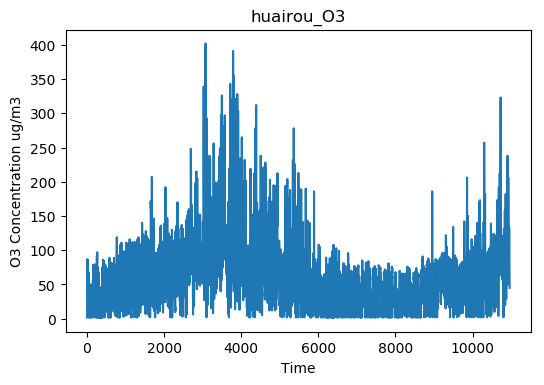

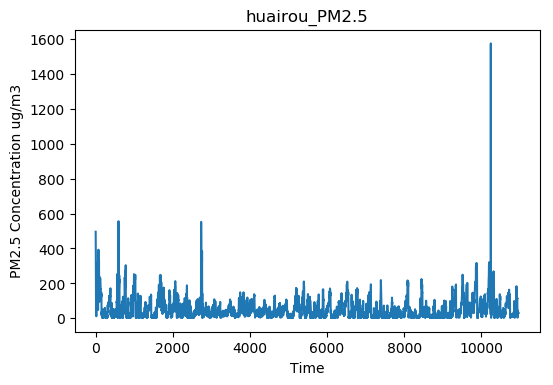

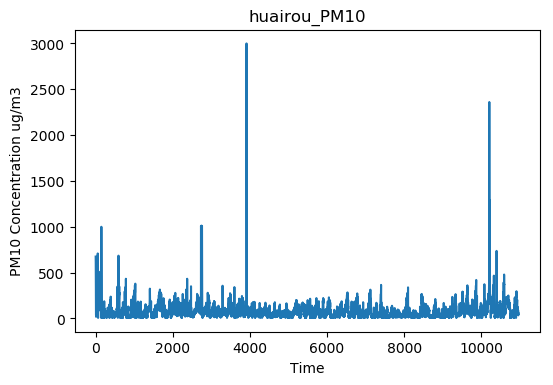

In [30]:
# huairou_aq
temp = air_quality[air_quality['station_id']=='huairou_aq']
temp = temp.sort_values(by='utc_time')
O3 = temp['O3']
PM = temp['PM2.5']
PM10 = temp['PM10']

x = range(0, len(O3), 1)
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100
plt.plot(x, O3, label='O3')
plt.xlabel('Time')
plt.ylabel('O3 Concentration ug/m3')
plt.title('huairou_O3')

plt.figure()
x = range(0, len(PM), 1)
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100 
plt.plot(x, PM, label='PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration ug/m3')
plt.title('huairou_PM2.5')

plt.figure()
x = range(0, len(PM10), 1)
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100 
plt.plot(x, PM10, label='PM10')
plt.xlabel('Time')
plt.ylabel('PM10 Concentration ug/m3')
plt.title('huairou_PM10')

Text(0.5, 1.0, 'xizhimenbei_PM2.5')

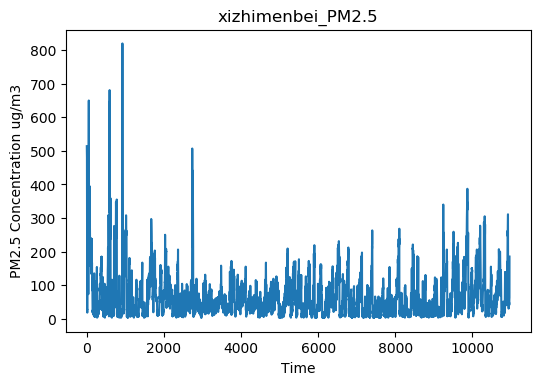

In [31]:
# xizhimenbei_aq
temp = air_quality[air_quality['station_id']=='xizhimenbei_aq']
temp = temp.sort_values(by='utc_time')
PM = temp['PM2.5']

plt.figure()
x = range(0, len(O3), 1)
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100 
plt.plot(x, PM, label='PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration ug/m3')
plt.title('xizhimenbei_PM2.5')

Text(0.5, 1.0, 'donggaocun_PM2.5')

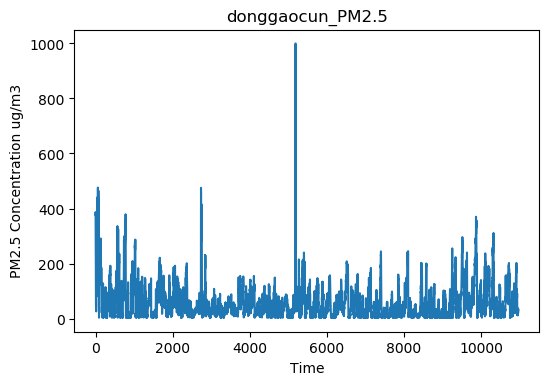

In [32]:
# dongggaocun_aq
temp = air_quality[air_quality['station_id']=='donggaocun_aq']
temp = temp.sort_values(by='utc_time')
PM = temp['PM2.5']

plt.figure()
x = range(0, len(O3), 1)
plt.rcParams['savefig.dpi'] = 100 
plt.rcParams['figure.dpi'] = 100 
plt.plot(x, PM, label='PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration ug/m3')
plt.title('donggaocun_PM2.5')

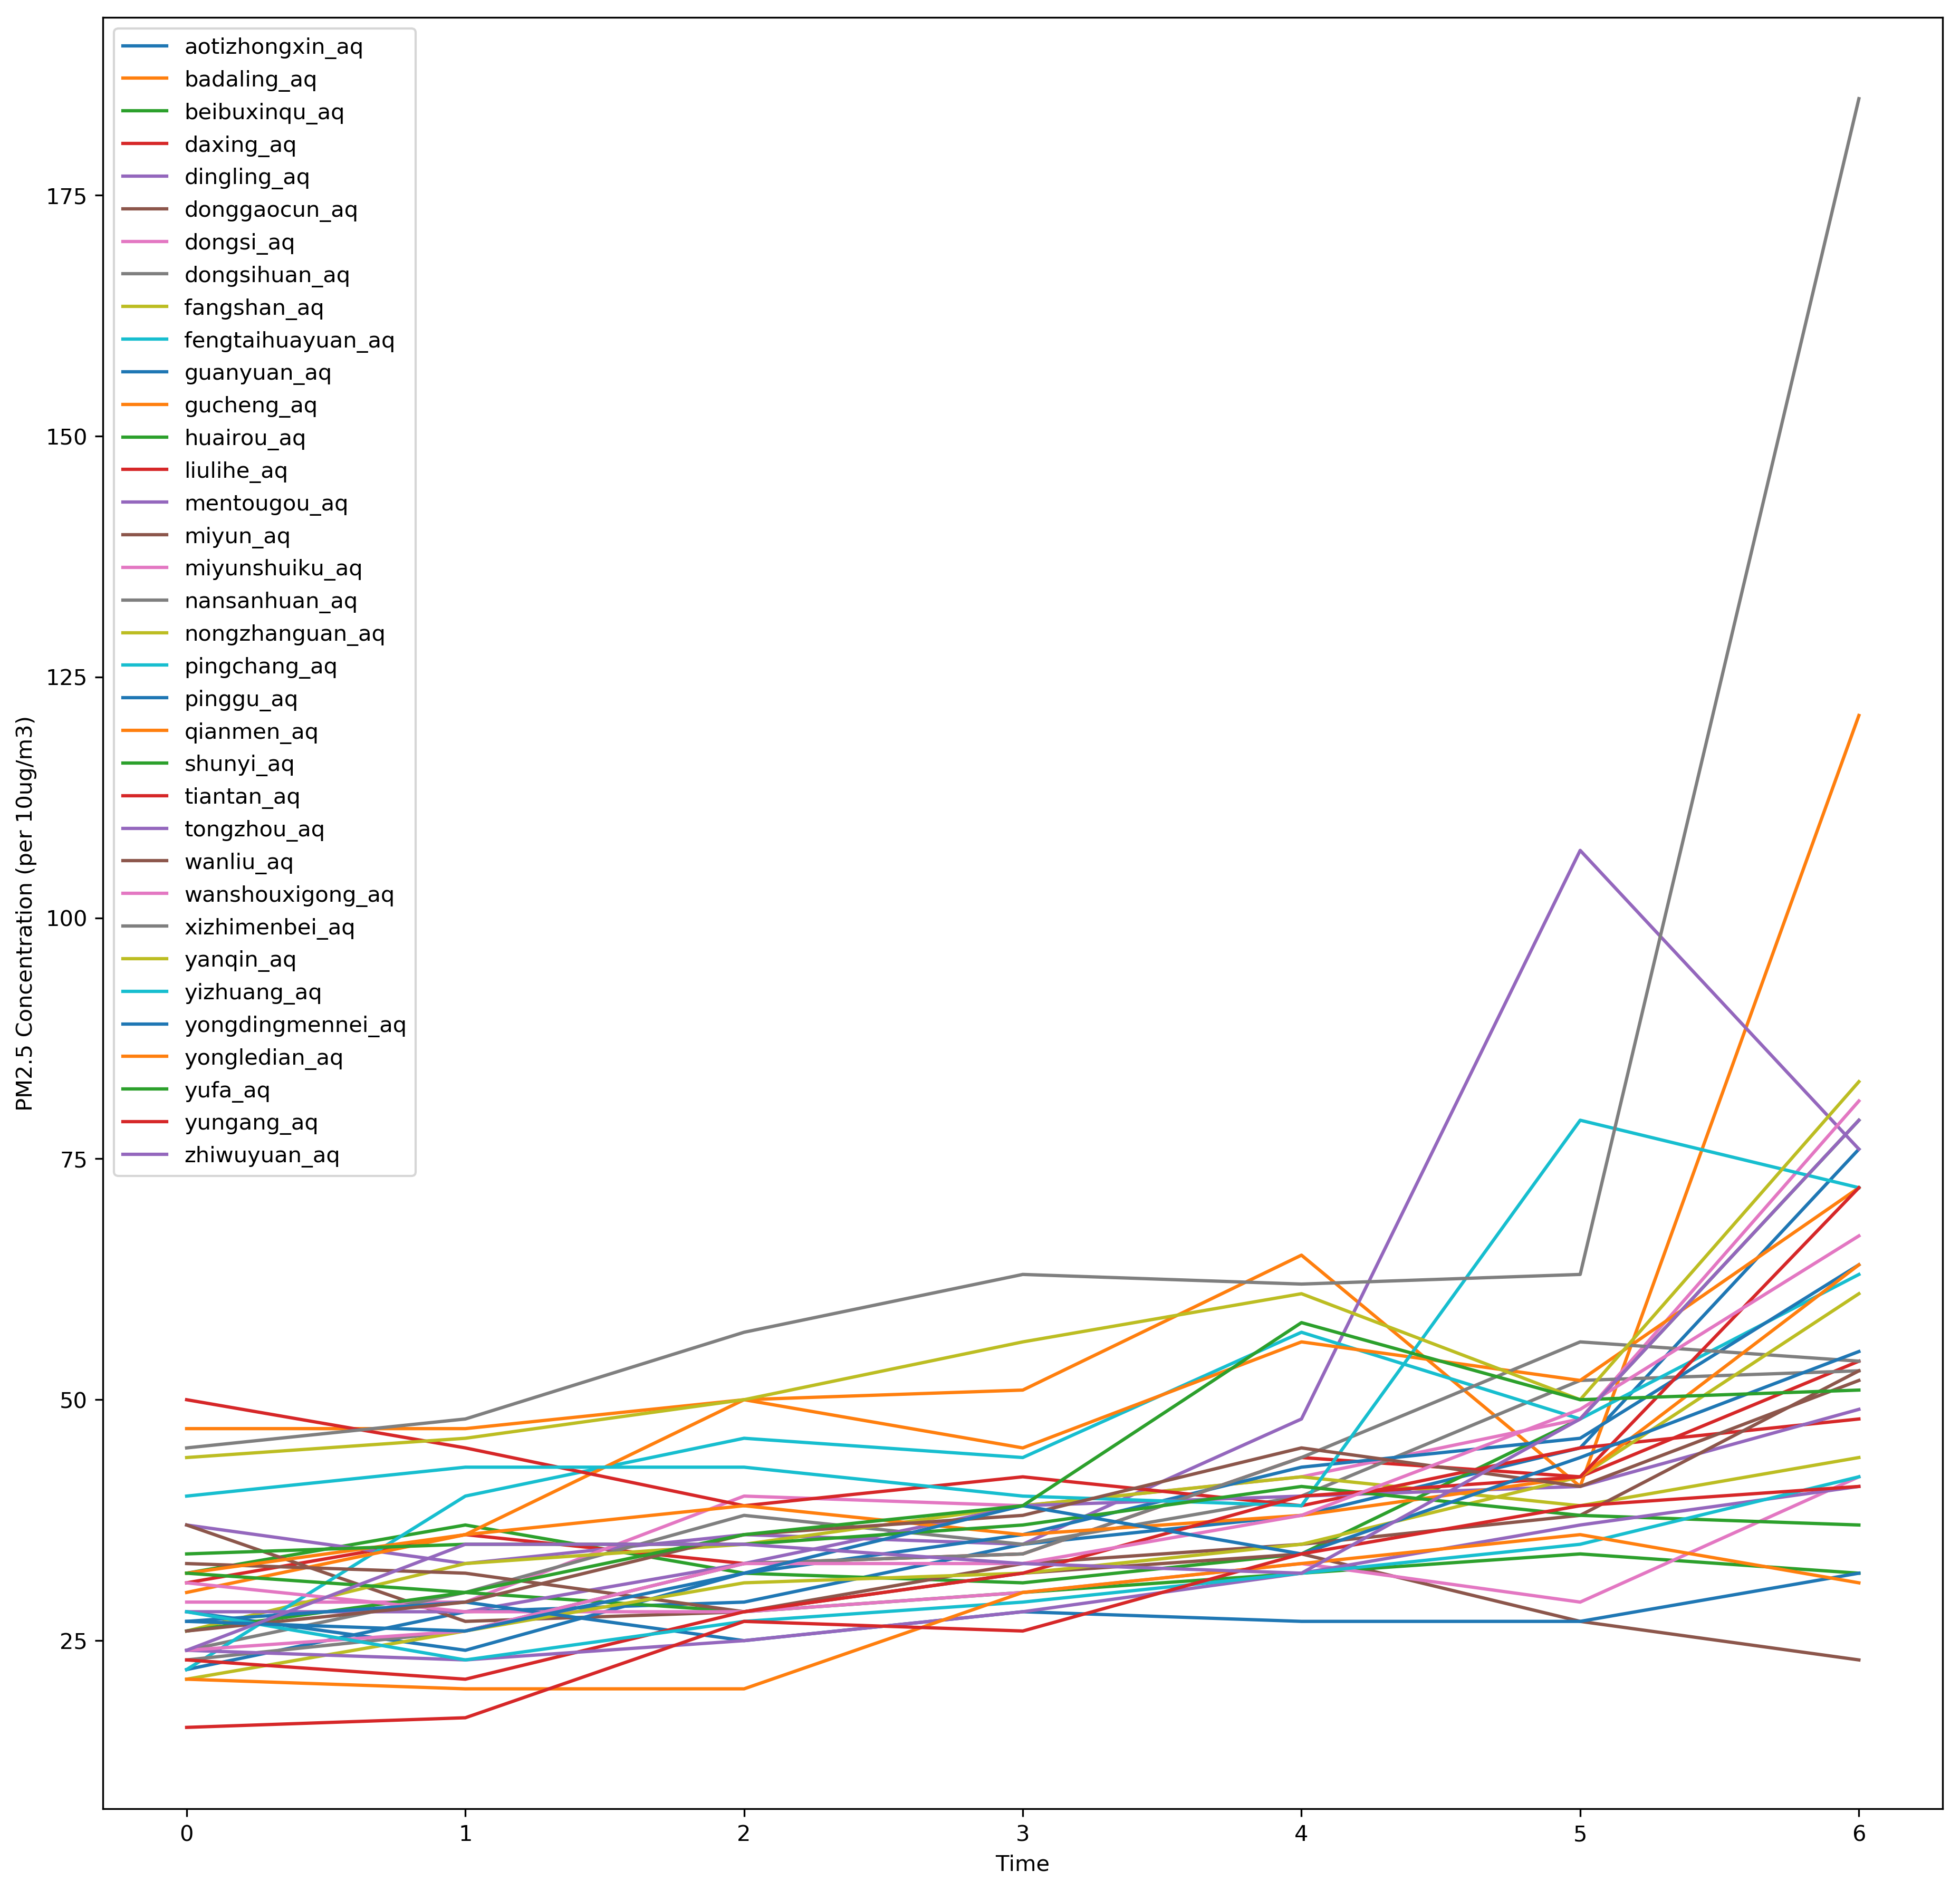

In [26]:
plt.figure(figsize=(15, 15))
station_all = np.unique(air_quality['station_id'])
temp = air_quality.sort_values(by='utc_time')
PM = temp[['station_id', 'PM2.5']]
PM = PM.dropna()
for i in station_all:
    new_temp = PM[PM['station_id'] == i]
    new_temp = new_temp[len(new_temp)-7:]
    x = range(0, len(new_temp), 1)
    plt.plot(x, new_temp['PM2.5'], label=i)
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration (per 10ug/m3)')
plt.legend()

In [17]:
# Data Processing
# fillna
air_quality.columns = ['station_id', 'utc_time', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
del air_quality['NO2'],air_quality['CO'],air_quality['SO2']

In [18]:
air_quality = air_quality.fillna(method='pad')
grid_weather = grid_weather.fillna(method='pad')
observed_weather = observed_weather.fillna(method='pad')

In [19]:
# load feature
train_feature = pd.read_csv('processed-data/train_weather.csv')
test_feature = pd.read_csv('processed-data/test_weather.csv')

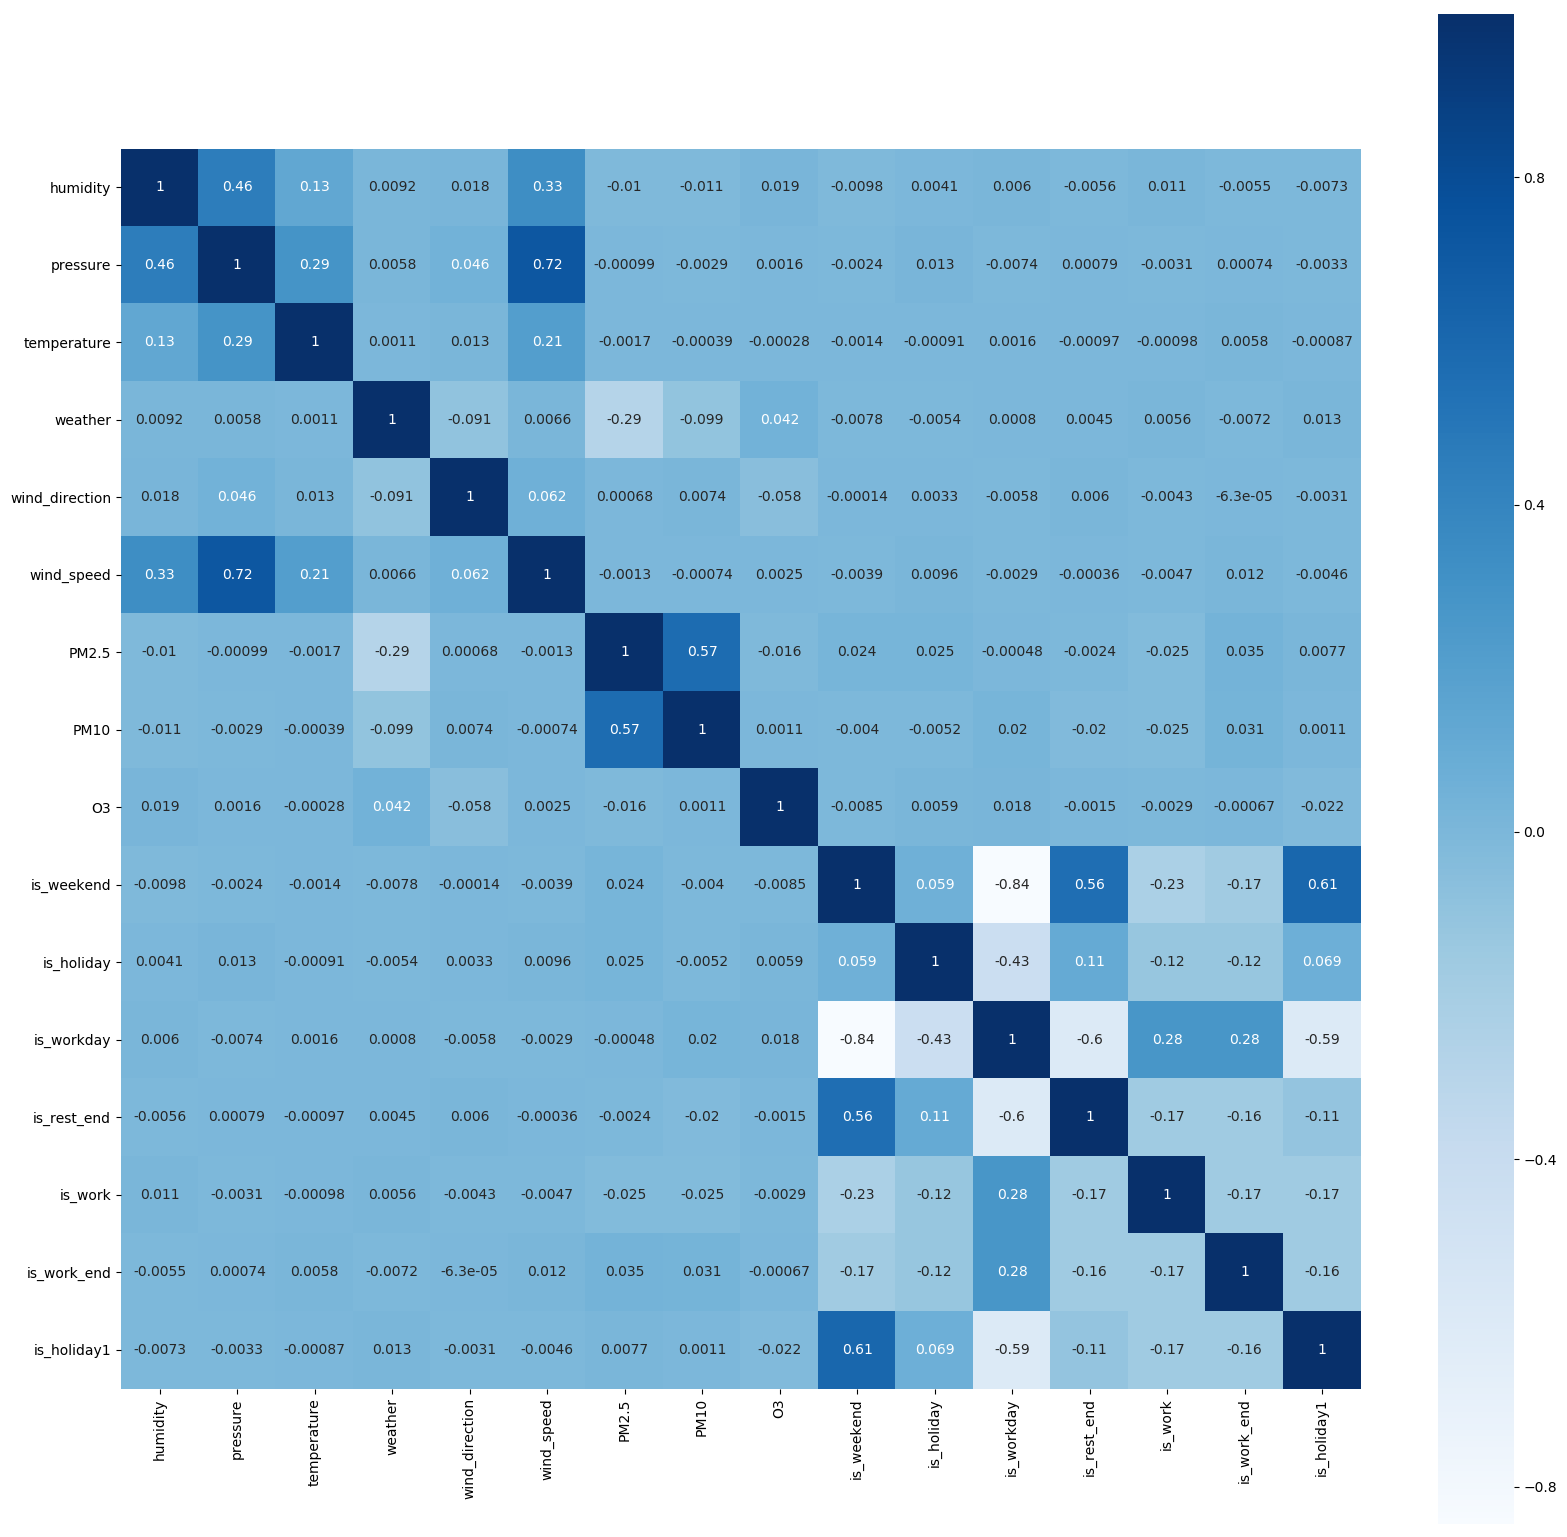

In [20]:
del_train_feature = train_feature.drop(['utc_time','station_id','SO2','CO', 'NO2'],axis=1)
# corr
dfData = del_train_feature.corr() 
plt.subplots(figsize=(20, 20))
sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [21]:
# feature importance
def load_data():
    train = pd.read_csv('processed-data/train_weather.csv')
    test = pd.read_csv('processed-data/test_weather.csv')

    train_label = train[['PM2.5','PM10','O3']]
    train_label = train_label.astype(float)
    train_X = train.drop(['PM2.5','PM10','NO2','CO','O3','SO2','station_id','utc_time'],axis=1)
    station_id = test['station_id'].values
    test =test.drop(['station_id','utc_time'],axis=1)

    return train_X, train_label, test,station_id


def smape_error(preds, train_data):
    labels = train_data.get_label()
    return 'error', np.mean(np.fabs(preds - labels) / (preds + labels) * 2), False

evals_result_0 = {} 
evals_result_1 = {} 
evals_result_2 = {} 

def model(X_train, y_train, pos):
    lgb_eval = lgb.Dataset(X_train[:2000],label=y_train[:2000])
    lgb_train = lgb.Dataset(X_train[2000:], label=y_train[2000:])
    
    
    model_param = {'lr': 0.005, 'depth': 10, 'tree': 1000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l2',
        'metric': {'l2', 'l1'},
        'max_depth': model_param['depth'],
        'num_leaves': model_param['leaf'],
        'min_data_in_leaf': 20,
        'learning_rate': model_param['lr'],
        'feature_fraction': 1,
        'bagging_fraction': model_param['sample'],
        'bagging_freq': 1,
        'bagging_seed': model_param['seed'],
        'verbose': 0
    }
    
    if pos==0:
        bst = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_train, lgb_eval],
            evals_result=evals_result_0,
            feval=smape_error,
            early_stopping_rounds=10,
            verbose_eval=True
        )
    if pos==1:
            bst = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_train, lgb_eval],
            evals_result=evals_result_1,
            feval=smape_error,
            early_stopping_rounds=10,
            verbose_eval=True
        )
    if pos==2:
        bst = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_train, lgb_eval],
            evals_result=evals_result_2,
            feval=smape_error,
            early_stopping_rounds=10,
            verbose_eval=True
        )
    return bst


def metrict(X,y,PM2_bst,PM10_bst,O3_bst):
    PM2_result = PM2_bst.predict(X)
    PM10_result = PM10_bst.predict(X)
    O3_result = O3_bst.predict(X)

    sampe_Pm2 = smape(y[:,0], PM2_result)
    sampe_Pm10 = smape(y[:,1], PM10_result)
    smape_O3 = smape(y[:,2], O3_result)
    total_smape = (sampe_Pm10+smape_O3+sampe_Pm2)/3.0
    print("smape=",total_smape)
train_X, train_label, test,station_id = load_data()
train_label = np.asarray(train_label)
PM2_bst = model(train_X, train_label[:,0], 0)
PM10_bst = model(train_X, train_label[:,1], 1)
O3_bst = model(train_X, train_label[:,2], 2)

[1]	training's l2: 1929.73	training's l1: 24.9275	training's error: 0.503469	valid_1's l2: 5652.12	valid_1's l1: 53.2832	valid_1's error: 0.852777
Train until valid scores didn't improve in 10 rounds.
[2]	training's l2: 1922.86	training's l1: 24.8802	training's error: 0.502713	valid_1's l2: 5639.24	valid_1's l1: 53.2109	valid_1's error: 0.851718
[3]	training's l2: 1916.07	training's l1: 24.8326	training's error: 0.501951	valid_1's l2: 5626.4	valid_1's l1: 53.1357	valid_1's error: 0.850607
[4]	training's l2: 1909.36	training's l1: 24.7855	training's error: 0.501194	valid_1's l2: 5613.37	valid_1's l1: 53.0633	valid_1's error: 0.849539
[5]	training's l2: 1902.68	training's l1: 24.7387	training's error: 0.500442	valid_1's l2: 5599.41	valid_1's l1: 52.9893	valid_1's error: 0.848454
[6]	training's l2: 1896.11	training's l1: 24.6924	training's error: 0.499699	valid_1's l2: 5584.71	valid_1's l1: 52.9133	valid_1's error: 0.847348
[7]	training's l2: 1889.45	training's l1: 24.646	training's error

[58]	training's l2: 1622.6	training's l1: 22.658	training's error: 0.466678	valid_1's l2: 5014.72	valid_1's l1: 50.0053	valid_1's error: 0.808198
[59]	training's l2: 1618.49	training's l1: 22.6273	training's error: 0.466183	valid_1's l2: 5006.57	valid_1's l1: 49.966	valid_1's error: 0.807704
[60]	training's l2: 1614.39	training's l1: 22.5966	training's error: 0.465687	valid_1's l2: 4997.87	valid_1's l1: 49.9235	valid_1's error: 0.807165
[61]	training's l2: 1610.22	training's l1: 22.5657	training's error: 0.465189	valid_1's l2: 4988.94	valid_1's l1: 49.8816	valid_1's error: 0.806655
[62]	training's l2: 1606.14	training's l1: 22.5353	training's error: 0.464699	valid_1's l2: 4980.22	valid_1's l1: 49.8404	valid_1's error: 0.80615
[63]	training's l2: 1602.19	training's l1: 22.5055	training's error: 0.464218	valid_1's l2: 4972.36	valid_1's l1: 49.7988	valid_1's error: 0.805606
[64]	training's l2: 1598.36	training's l1: 22.4762	training's error: 0.463745	valid_1's l2: 4963.53	valid_1's l1: 49

[115]	training's l2: 1434.95	training's l1: 21.2114	training's error: 0.443172	valid_1's l2: 4595.65	valid_1's l1: 47.9441	valid_1's error: 0.782748
[116]	training's l2: 1432.32	training's l1: 21.1904	training's error: 0.442825	valid_1's l2: 4590.01	valid_1's l1: 47.9143	valid_1's error: 0.782382
[117]	training's l2: 1429.63	training's l1: 21.1689	training's error: 0.442471	valid_1's l2: 4583.88	valid_1's l1: 47.8831	valid_1's error: 0.781991
[118]	training's l2: 1427.03	training's l1: 21.1483	training's error: 0.442131	valid_1's l2: 4576.13	valid_1's l1: 47.8501	valid_1's error: 0.781599
[119]	training's l2: 1424.64	training's l1: 21.1282	training's error: 0.441798	valid_1's l2: 4570	valid_1's l1: 47.8167	valid_1's error: 0.781174
[120]	training's l2: 1422.08	training's l1: 21.1075	training's error: 0.441455	valid_1's l2: 4564.58	valid_1's l1: 47.7884	valid_1's error: 0.78083
[121]	training's l2: 1419.61	training's l1: 21.0874	training's error: 0.441122	valid_1's l2: 4558.41	valid_1's

[171]	training's l2: 1315.75	training's l1: 20.2061	training's error: 0.426272	valid_1's l2: 4298.19	valid_1's l1: 46.4176	valid_1's error: 0.764019
[172]	training's l2: 1313.93	training's l1: 20.1906	training's error: 0.426007	valid_1's l2: 4293.31	valid_1's l1: 46.3905	valid_1's error: 0.763691
[173]	training's l2: 1312.17	training's l1: 20.1752	training's error: 0.425745	valid_1's l2: 4286.29	valid_1's l1: 46.3615	valid_1's error: 0.763353
[174]	training's l2: 1310.49	training's l1: 20.1607	training's error: 0.425498	valid_1's l2: 4281.26	valid_1's l1: 46.3357	valid_1's error: 0.763036
[175]	training's l2: 1308.9	training's l1: 20.1465	training's error: 0.42525	valid_1's l2: 4277.54	valid_1's l1: 46.3136	valid_1's error: 0.762759
[176]	training's l2: 1307.27	training's l1: 20.1313	training's error: 0.424989	valid_1's l2: 4273.58	valid_1's l1: 46.2896	valid_1's error: 0.76246
[177]	training's l2: 1305.65	training's l1: 20.1167	training's error: 0.42474	valid_1's l2: 4269.82	valid_1's

[228]	training's l2: 1233.94	training's l1: 19.4659	training's error: 0.41345	valid_1's l2: 4080.81	valid_1's l1: 45.2053	valid_1's error: 0.749141
[229]	training's l2: 1232.79	training's l1: 19.4556	training's error: 0.413267	valid_1's l2: 4077.92	valid_1's l1: 45.1912	valid_1's error: 0.748953
[230]	training's l2: 1231.41	training's l1: 19.4436	training's error: 0.413063	valid_1's l2: 4072.44	valid_1's l1: 45.168	valid_1's error: 0.748676
[231]	training's l2: 1230.11	training's l1: 19.4319	training's error: 0.412863	valid_1's l2: 4067.63	valid_1's l1: 45.1469	valid_1's error: 0.748426
[232]	training's l2: 1228.99	training's l1: 19.421	training's error: 0.41267	valid_1's l2: 4064.75	valid_1's l1: 45.1293	valid_1's error: 0.74821
[233]	training's l2: 1227.83	training's l1: 19.4101	training's error: 0.412479	valid_1's l2: 4061.49	valid_1's l1: 45.1074	valid_1's error: 0.747928
[234]	training's l2: 1226.65	training's l1: 19.3989	training's error: 0.412283	valid_1's l2: 4058.65	valid_1's 

[284]	training's l2: 1175.41	training's l1: 18.9199	training's error: 0.403856	valid_1's l2: 3912.64	valid_1's l1: 44.2543	valid_1's error: 0.737197
[285]	training's l2: 1174.57	training's l1: 18.912	training's error: 0.403716	valid_1's l2: 3910.5	valid_1's l1: 44.243	valid_1's error: 0.737053
[286]	training's l2: 1173.67	training's l1: 18.9036	training's error: 0.403567	valid_1's l2: 3908.09	valid_1's l1: 44.2284	valid_1's error: 0.736878
[287]	training's l2: 1172.89	training's l1: 18.8958	training's error: 0.403428	valid_1's l2: 3905.07	valid_1's l1: 44.2159	valid_1's error: 0.736726
[288]	training's l2: 1172.12	training's l1: 18.888	training's error: 0.403283	valid_1's l2: 3902.24	valid_1's l1: 44.2033	valid_1's error: 0.736578
[289]	training's l2: 1171.25	training's l1: 18.8799	training's error: 0.403141	valid_1's l2: 3899.75	valid_1's l1: 44.1878	valid_1's error: 0.736381
[290]	training's l2: 1170.43	training's l1: 18.872	training's error: 0.402996	valid_1's l2: 3896.97	valid_1's 

[341]	training's l2: 1130.88	training's l1: 18.4988	training's error: 0.396369	valid_1's l2: 3790.7	valid_1's l1: 43.5853	valid_1's error: 0.728735
[342]	training's l2: 1130.12	training's l1: 18.4922	training's error: 0.396254	valid_1's l2: 3788.5	valid_1's l1: 43.5705	valid_1's error: 0.728526
[343]	training's l2: 1129.21	training's l1: 18.4851	training's error: 0.396137	valid_1's l2: 3787.37	valid_1's l1: 43.5629	valid_1's error: 0.728409
[344]	training's l2: 1128.43	training's l1: 18.479	training's error: 0.396034	valid_1's l2: 3785.13	valid_1's l1: 43.5507	valid_1's error: 0.728262
[345]	training's l2: 1127.61	training's l1: 18.4718	training's error: 0.395912	valid_1's l2: 3781.59	valid_1's l1: 43.5367	valid_1's error: 0.728102
[346]	training's l2: 1126.87	training's l1: 18.465	training's error: 0.395794	valid_1's l2: 3778.24	valid_1's l1: 43.522	valid_1's error: 0.727931
[347]	training's l2: 1126.16	training's l1: 18.4589	training's error: 0.395686	valid_1's l2: 3776.73	valid_1's 

[397]	training's l2: 1095.12	training's l1: 18.1709	training's error: 0.390576	valid_1's l2: 3695.55	valid_1's l1: 43.07	valid_1's error: 0.721956
[398]	training's l2: 1094.48	training's l1: 18.1652	training's error: 0.390472	valid_1's l2: 3694.68	valid_1's l1: 43.0649	valid_1's error: 0.721872
[399]	training's l2: 1094.01	training's l1: 18.16	training's error: 0.390374	valid_1's l2: 3693.6	valid_1's l1: 43.056	valid_1's error: 0.721749
[400]	training's l2: 1093.45	training's l1: 18.1549	training's error: 0.390284	valid_1's l2: 3691.8	valid_1's l1: 43.0445	valid_1's error: 0.721589
[401]	training's l2: 1092.76	training's l1: 18.1495	training's error: 0.390195	valid_1's l2: 3690.06	valid_1's l1: 43.0353	valid_1's error: 0.721456
[402]	training's l2: 1092.28	training's l1: 18.1447	training's error: 0.390111	valid_1's l2: 3689.03	valid_1's l1: 43.0268	valid_1's error: 0.721329
[403]	training's l2: 1091.63	training's l1: 18.1392	training's error: 0.390016	valid_1's l2: 3686.46	valid_1's l1

[453]	training's l2: 1065.53	training's l1: 17.9038	training's error: 0.385871	valid_1's l2: 3605.11	valid_1's l1: 42.6326	valid_1's error: 0.716437
[454]	training's l2: 1065.15	training's l1: 17.8999	training's error: 0.385798	valid_1's l2: 3604.21	valid_1's l1: 42.628	valid_1's error: 0.716379
[455]	training's l2: 1064.78	training's l1: 17.8962	training's error: 0.385733	valid_1's l2: 3603.65	valid_1's l1: 42.6244	valid_1's error: 0.716337
[456]	training's l2: 1064.43	training's l1: 17.8929	training's error: 0.38567	valid_1's l2: 3602.98	valid_1's l1: 42.6194	valid_1's error: 0.716266
[457]	training's l2: 1063.93	training's l1: 17.8885	training's error: 0.385597	valid_1's l2: 3601.98	valid_1's l1: 42.6115	valid_1's error: 0.716149
[458]	training's l2: 1063.42	training's l1: 17.8848	training's error: 0.385537	valid_1's l2: 3600.58	valid_1's l1: 42.6046	valid_1's error: 0.716065
[459]	training's l2: 1063.05	training's l1: 17.8808	training's error: 0.38546	valid_1's l2: 3599.8	valid_1's

[510]	training's l2: 1039.57	training's l1: 17.6854	training's error: 0.382113	valid_1's l2: 3525.29	valid_1's l1: 42.2539	valid_1's error: 0.711668
[511]	training's l2: 1039.12	training's l1: 17.6819	training's error: 0.382059	valid_1's l2: 3523.07	valid_1's l1: 42.2461	valid_1's error: 0.711593
[512]	training's l2: 1038.38	training's l1: 17.6767	training's error: 0.38198	valid_1's l2: 3520.24	valid_1's l1: 42.2361	valid_1's error: 0.711501
[513]	training's l2: 1037.94	training's l1: 17.6732	training's error: 0.381924	valid_1's l2: 3518.72	valid_1's l1: 42.2312	valid_1's error: 0.711442
[514]	training's l2: 1037.44	training's l1: 17.6696	training's error: 0.381863	valid_1's l2: 3515.71	valid_1's l1: 42.2219	valid_1's error: 0.711364
[515]	training's l2: 1037.11	training's l1: 17.6661	training's error: 0.381799	valid_1's l2: 3513.8	valid_1's l1: 42.2152	valid_1's error: 0.711282
[516]	training's l2: 1036.9	training's l1: 17.6638	training's error: 0.381753	valid_1's l2: 3513.75	valid_1'

[568]	training's l2: 1017.37	training's l1: 17.5032	training's error: 0.379043	valid_1's l2: 3455.75	valid_1's l1: 41.9175	valid_1's error: 0.707567
[569]	training's l2: 1016.93	training's l1: 17.5002	training's error: 0.378995	valid_1's l2: 3454.53	valid_1's l1: 41.9109	valid_1's error: 0.70748
[570]	training's l2: 1016.61	training's l1: 17.4974	training's error: 0.378949	valid_1's l2: 3454.14	valid_1's l1: 41.9071	valid_1's error: 0.707424
[571]	training's l2: 1016.41	training's l1: 17.4954	training's error: 0.378913	valid_1's l2: 3452.88	valid_1's l1: 41.903	valid_1's error: 0.707386
[572]	training's l2: 1016.03	training's l1: 17.4925	training's error: 0.378861	valid_1's l2: 3452.29	valid_1's l1: 41.8981	valid_1's error: 0.707331
[573]	training's l2: 1015.58	training's l1: 17.4887	training's error: 0.378802	valid_1's l2: 3449.29	valid_1's l1: 41.8889	valid_1's error: 0.707254
[574]	training's l2: 1015.2	training's l1: 17.4855	training's error: 0.378751	valid_1's l2: 3447.91	valid_1'

[624]	training's l2: 998.83	training's l1: 17.3636	training's error: 0.376799	valid_1's l2: 3397.91	valid_1's l1: 41.6511	valid_1's error: 0.704406
[625]	training's l2: 998.546	training's l1: 17.3616	training's error: 0.376766	valid_1's l2: 3395.65	valid_1's l1: 41.6432	valid_1's error: 0.704321
[626]	training's l2: 998.336	training's l1: 17.3597	training's error: 0.376734	valid_1's l2: 3395.45	valid_1's l1: 41.6422	valid_1's error: 0.704303
[627]	training's l2: 998.166	training's l1: 17.3581	training's error: 0.3767	valid_1's l2: 3395.08	valid_1's l1: 41.6397	valid_1's error: 0.704265
[628]	training's l2: 997.581	training's l1: 17.3537	training's error: 0.376639	valid_1's l2: 3391.67	valid_1's l1: 41.6272	valid_1's error: 0.704148
[629]	training's l2: 996.957	training's l1: 17.3499	training's error: 0.376595	valid_1's l2: 3387.82	valid_1's l1: 41.6144	valid_1's error: 0.704028
[630]	training's l2: 996.652	training's l1: 17.3479	training's error: 0.376557	valid_1's l2: 3387.35	valid_1'

[682]	training's l2: 982.643	training's l1: 17.2484	training's error: 0.375043	valid_1's l2: 3331.84	valid_1's l1: 41.3667	valid_1's error: 0.701196
[683]	training's l2: 982.463	training's l1: 17.2471	training's error: 0.375022	valid_1's l2: 3330.51	valid_1's l1: 41.3635	valid_1's error: 0.701176
[684]	training's l2: 982.339	training's l1: 17.2461	training's error: 0.375003	valid_1's l2: 3330.3	valid_1's l1: 41.3616	valid_1's error: 0.701143
[685]	training's l2: 982.184	training's l1: 17.2452	training's error: 0.37499	valid_1's l2: 3330.49	valid_1's l1: 41.3629	valid_1's error: 0.701158
[686]	training's l2: 981.817	training's l1: 17.2429	training's error: 0.374957	valid_1's l2: 3328.76	valid_1's l1: 41.3567	valid_1's error: 0.701094
[687]	training's l2: 981.71	training's l1: 17.242	training's error: 0.374942	valid_1's l2: 3327.7	valid_1's l1: 41.3528	valid_1's error: 0.701049
[688]	training's l2: 981.553	training's l1: 17.2409	training's error: 0.374926	valid_1's l2: 3326.57	valid_1's 

[738]	training's l2: 969.443	training's l1: 17.1574	training's error: 0.373703	valid_1's l2: 3276.79	valid_1's l1: 41.1171	valid_1's error: 0.698506
[739]	training's l2: 969.214	training's l1: 17.1563	training's error: 0.37369	valid_1's l2: 3276.33	valid_1's l1: 41.1165	valid_1's error: 0.698507
[740]	training's l2: 969.059	training's l1: 17.1553	training's error: 0.373676	valid_1's l2: 3274.61	valid_1's l1: 41.1111	valid_1's error: 0.69847
[741]	training's l2: 968.765	training's l1: 17.1532	training's error: 0.373648	valid_1's l2: 3274.26	valid_1's l1: 41.106	valid_1's error: 0.698397
[742]	training's l2: 968.595	training's l1: 17.152	training's error: 0.373631	valid_1's l2: 3273.38	valid_1's l1: 41.102	valid_1's error: 0.69836
[743]	training's l2: 968.193	training's l1: 17.1495	training's error: 0.3736	valid_1's l2: 3271.16	valid_1's l1: 41.095	valid_1's error: 0.698301
[744]	training's l2: 967.964	training's l1: 17.1479	training's error: 0.373577	valid_1's l2: 3270.95	valid_1's l1: 

[796]	training's l2: 955.366	training's l1: 17.0637	training's error: 0.372453	valid_1's l2: 3221.02	valid_1's l1: 40.8766	valid_1's error: 0.696181
[797]	training's l2: 955.3	training's l1: 17.0633	training's error: 0.37245	valid_1's l2: 3220.99	valid_1's l1: 40.876	valid_1's error: 0.696167
[798]	training's l2: 954.982	training's l1: 17.0607	training's error: 0.372406	valid_1's l2: 3219.39	valid_1's l1: 40.8715	valid_1's error: 0.696132
[799]	training's l2: 954.799	training's l1: 17.0596	training's error: 0.372391	valid_1's l2: 3219.04	valid_1's l1: 40.8678	valid_1's error: 0.696086
[800]	training's l2: 954.441	training's l1: 17.0568	training's error: 0.372355	valid_1's l2: 3216.73	valid_1's l1: 40.8576	valid_1's error: 0.695992
[801]	training's l2: 954.332	training's l1: 17.056	training's error: 0.372341	valid_1's l2: 3216.47	valid_1's l1: 40.8552	valid_1's error: 0.695957
[802]	training's l2: 954.178	training's l1: 17.0547	training's error: 0.372319	valid_1's l2: 3214.73	valid_1's 

[853]	training's l2: 943.363	training's l1: 16.9792	training's error: 0.371235	valid_1's l2: 3181.5	valid_1's l1: 40.6929	valid_1's error: 0.694152
[854]	training's l2: 943.163	training's l1: 16.978	training's error: 0.371222	valid_1's l2: 3179.83	valid_1's l1: 40.6868	valid_1's error: 0.694106
[855]	training's l2: 942.897	training's l1: 16.9766	training's error: 0.371204	valid_1's l2: 3179.44	valid_1's l1: 40.684	valid_1's error: 0.69408
[856]	training's l2: 942.575	training's l1: 16.9741	training's error: 0.371176	valid_1's l2: 3177.57	valid_1's l1: 40.6763	valid_1's error: 0.694023
[857]	training's l2: 942.322	training's l1: 16.9714	training's error: 0.371131	valid_1's l2: 3176.56	valid_1's l1: 40.6721	valid_1's error: 0.69399
[858]	training's l2: 942.102	training's l1: 16.9695	training's error: 0.371098	valid_1's l2: 3175.21	valid_1's l1: 40.6679	valid_1's error: 0.69396
[859]	training's l2: 941.723	training's l1: 16.9662	training's error: 0.371045	valid_1's l2: 3173.26	valid_1's l

[911]	training's l2: 930.219	training's l1: 16.8749	training's error: 0.369666	valid_1's l2: 3136.88	valid_1's l1: 40.5	valid_1's error: 0.692107
[912]	training's l2: 929.671	training's l1: 16.8712	training's error: 0.369616	valid_1's l2: 3135.11	valid_1's l1: 40.4918	valid_1's error: 0.69201
[913]	training's l2: 929.472	training's l1: 16.8695	training's error: 0.369589	valid_1's l2: 3134.75	valid_1's l1: 40.489	valid_1's error: 0.691965
[914]	training's l2: 929.315	training's l1: 16.8682	training's error: 0.369569	valid_1's l2: 3133.59	valid_1's l1: 40.4839	valid_1's error: 0.691902
[915]	training's l2: 929.094	training's l1: 16.8659	training's error: 0.36953	valid_1's l2: 3133.05	valid_1's l1: 40.4814	valid_1's error: 0.691868
[916]	training's l2: 928.84	training's l1: 16.8637	training's error: 0.369497	valid_1's l2: 3132.78	valid_1's l1: 40.4795	valid_1's error: 0.691841
[917]	training's l2: 928.619	training's l1: 16.8611	training's error: 0.369449	valid_1's l2: 3132.26	valid_1's l1

[967]	training's l2: 918.504	training's l1: 16.7809	training's error: 0.368227	valid_1's l2: 3099.36	valid_1's l1: 40.3111	valid_1's error: 0.68987
[968]	training's l2: 918.364	training's l1: 16.7797	training's error: 0.368206	valid_1's l2: 3099.29	valid_1's l1: 40.3099	valid_1's error: 0.689848
[969]	training's l2: 918.252	training's l1: 16.7788	training's error: 0.368188	valid_1's l2: 3099.13	valid_1's l1: 40.3089	valid_1's error: 0.689828
[970]	training's l2: 918.19	training's l1: 16.7781	training's error: 0.368172	valid_1's l2: 3099.01	valid_1's l1: 40.3082	valid_1's error: 0.689821
[971]	training's l2: 917.885	training's l1: 16.7756	training's error: 0.368135	valid_1's l2: 3098.52	valid_1's l1: 40.3043	valid_1's error: 0.689772
[972]	training's l2: 917.649	training's l1: 16.7738	training's error: 0.368107	valid_1's l2: 3096.95	valid_1's l1: 40.2982	valid_1's error: 0.689715
[973]	training's l2: 917.488	training's l1: 16.7728	training's error: 0.368095	valid_1's l2: 3096.87	valid_1

[22]	training's l2: 6819.18	training's l1: 40.8449	training's error: 0.430709	valid_1's l2: 9257	valid_1's l1: 74.343	valid_1's error: 0.622135
[23]	training's l2: 6803.35	training's l1: 40.7996	training's error: 0.430349	valid_1's l2: 9245.53	valid_1's l1: 74.2806	valid_1's error: 0.621616
[24]	training's l2: 6787.33	training's l1: 40.7546	training's error: 0.429989	valid_1's l2: 9232.81	valid_1's l1: 74.2044	valid_1's error: 0.620975
[25]	training's l2: 6771	training's l1: 40.71	training's error: 0.429635	valid_1's l2: 9221.58	valid_1's l1: 74.1376	valid_1's error: 0.620411
[26]	training's l2: 6754.71	training's l1: 40.6635	training's error: 0.429261	valid_1's l2: 9209.73	valid_1's l1: 74.0668	valid_1's error: 0.619818
[27]	training's l2: 6737.45	training's l1: 40.6177	training's error: 0.428898	valid_1's l2: 9197.52	valid_1's l1: 73.9982	valid_1's error: 0.619249
[28]	training's l2: 6721.25	training's l1: 40.5734	training's error: 0.428545	valid_1's l2: 9184.56	valid_1's l1: 73.9235

[78]	training's l2: 6051.6	training's l1: 38.6823	training's error: 0.412981	valid_1's l2: 8709.85	valid_1's l1: 71.155	valid_1's error: 0.595483
[79]	training's l2: 6040.2	training's l1: 38.6462	training's error: 0.412671	valid_1's l2: 8701.47	valid_1's l1: 71.1118	valid_1's error: 0.595118
[80]	training's l2: 6030.08	training's l1: 38.6137	training's error: 0.412393	valid_1's l2: 8693.16	valid_1's l1: 71.0659	valid_1's error: 0.59473
[81]	training's l2: 6019.08	training's l1: 38.582	training's error: 0.412123	valid_1's l2: 8686.49	valid_1's l1: 71.0271	valid_1's error: 0.594401
[82]	training's l2: 6008.86	training's l1: 38.548	training's error: 0.411829	valid_1's l2: 8678.7	valid_1's l1: 70.9801	valid_1's error: 0.593991
[83]	training's l2: 5997.95	training's l1: 38.5183	training's error: 0.411578	valid_1's l2: 8672.23	valid_1's l1: 70.9406	valid_1's error: 0.593652
[84]	training's l2: 5987.82	training's l1: 38.4879	training's error: 0.411317	valid_1's l2: 8665.5	valid_1's l1: 70.897

[134]	training's l2: 5544.16	training's l1: 37.0689	training's error: 0.39883	valid_1's l2: 8340.65	valid_1's l1: 68.974	valid_1's error: 0.576482
[135]	training's l2: 5536.79	training's l1: 37.0448	training's error: 0.398614	valid_1's l2: 8335.29	valid_1's l1: 68.9392	valid_1's error: 0.576182
[136]	training's l2: 5529.67	training's l1: 37.0182	training's error: 0.398367	valid_1's l2: 8329.89	valid_1's l1: 68.9043	valid_1's error: 0.575877
[137]	training's l2: 5522.08	training's l1: 36.9924	training's error: 0.39813	valid_1's l2: 8324.91	valid_1's l1: 68.8731	valid_1's error: 0.575599
[138]	training's l2: 5515.36	training's l1: 36.9688	training's error: 0.397916	valid_1's l2: 8320.17	valid_1's l1: 68.843	valid_1's error: 0.575328
[139]	training's l2: 5508.15	training's l1: 36.9451	training's error: 0.397703	valid_1's l2: 8313.92	valid_1's l1: 68.8086	valid_1's error: 0.575036
[140]	training's l2: 5500.83	training's l1: 36.9208	training's error: 0.39748	valid_1's l2: 8308.42	valid_1's 

[191]	training's l2: 5193.83	training's l1: 35.8398	training's error: 0.387391	valid_1's l2: 8074.2	valid_1's l1: 67.2502	valid_1's error: 0.5612
[192]	training's l2: 5188.68	training's l1: 35.8213	training's error: 0.387215	valid_1's l2: 8071.13	valid_1's l1: 67.2266	valid_1's error: 0.56098
[193]	training's l2: 5183.83	training's l1: 35.8049	training's error: 0.387061	valid_1's l2: 8067.35	valid_1's l1: 67.1993	valid_1's error: 0.560722
[194]	training's l2: 5178.64	training's l1: 35.788	training's error: 0.386901	valid_1's l2: 8064.44	valid_1's l1: 67.175	valid_1's error: 0.560496
[195]	training's l2: 5173.62	training's l1: 35.7686	training's error: 0.386712	valid_1's l2: 8060.04	valid_1's l1: 67.1464	valid_1's error: 0.560246
[196]	training's l2: 5168.65	training's l1: 35.7487	training's error: 0.386518	valid_1's l2: 8057.25	valid_1's l1: 67.1247	valid_1's error: 0.560032
[197]	training's l2: 5163.53	training's l1: 35.7294	training's error: 0.38633	valid_1's l2: 8053.15	valid_1's l1

[246]	training's l2: 4944.17	training's l1: 34.9137	training's error: 0.378352	valid_1's l2: 7895.57	valid_1's l1: 65.9665	valid_1's error: 0.549381
[247]	training's l2: 4940.29	training's l1: 34.8976	training's error: 0.378188	valid_1's l2: 7894.15	valid_1's l1: 65.9503	valid_1's error: 0.549218
[248]	training's l2: 4936.26	training's l1: 34.8813	training's error: 0.378028	valid_1's l2: 7891.43	valid_1's l1: 65.9268	valid_1's error: 0.548997
[249]	training's l2: 4932.38	training's l1: 34.8667	training's error: 0.377884	valid_1's l2: 7889.14	valid_1's l1: 65.9128	valid_1's error: 0.548863
[250]	training's l2: 4929.34	training's l1: 34.8509	training's error: 0.377725	valid_1's l2: 7885.59	valid_1's l1: 65.8905	valid_1's error: 0.548648
[251]	training's l2: 4925.93	training's l1: 34.8371	training's error: 0.377586	valid_1's l2: 7883.8	valid_1's l1: 65.8753	valid_1's error: 0.548489
[252]	training's l2: 4922.72	training's l1: 34.8245	training's error: 0.377457	valid_1's l2: 7881.54	valid_

[303]	training's l2: 4744.15	training's l1: 34.1189	training's error: 0.370359	valid_1's l2: 7759.53	valid_1's l1: 64.977	valid_1's error: 0.53989
[304]	training's l2: 4740.43	training's l1: 34.1074	training's error: 0.370248	valid_1's l2: 7757.21	valid_1's l1: 64.9621	valid_1's error: 0.539753
[305]	training's l2: 4737.47	training's l1: 34.097	training's error: 0.370144	valid_1's l2: 7755.57	valid_1's l1: 64.9474	valid_1's error: 0.539619
[306]	training's l2: 4734.76	training's l1: 34.0845	training's error: 0.370015	valid_1's l2: 7753.54	valid_1's l1: 64.9316	valid_1's error: 0.539462
[307]	training's l2: 4731.9	training's l1: 34.0718	training's error: 0.369889	valid_1's l2: 7749.32	valid_1's l1: 64.9096	valid_1's error: 0.539264
[308]	training's l2: 4726.82	training's l1: 34.0577	training's error: 0.369759	valid_1's l2: 7745.8	valid_1's l1: 64.8817	valid_1's error: 0.539038
[309]	training's l2: 4723.47	training's l1: 34.047	training's error: 0.369652	valid_1's l2: 7744.58	valid_1's l

[361]	training's l2: 4559.51	training's l1: 33.4392	training's error: 0.363569	valid_1's l2: 7646.15	valid_1's l1: 64.0958	valid_1's error: 0.53117
[362]	training's l2: 4555.55	training's l1: 33.4283	training's error: 0.363469	valid_1's l2: 7644.97	valid_1's l1: 64.0789	valid_1's error: 0.530997
[363]	training's l2: 4553.16	training's l1: 33.4174	training's error: 0.363355	valid_1's l2: 7643.62	valid_1's l1: 64.0673	valid_1's error: 0.530882
[364]	training's l2: 4548.84	training's l1: 33.4062	training's error: 0.363257	valid_1's l2: 7642.54	valid_1's l1: 64.0549	valid_1's error: 0.530752
[365]	training's l2: 4546.7	training's l1: 33.3984	training's error: 0.363175	valid_1's l2: 7641.19	valid_1's l1: 64.0455	valid_1's error: 0.530659
[366]	training's l2: 4542.01	training's l1: 33.387	training's error: 0.363073	valid_1's l2: 7638.6	valid_1's l1: 64.0255	valid_1's error: 0.530496
[367]	training's l2: 4537.64	training's l1: 33.3763	training's error: 0.362976	valid_1's l2: 7636.93	valid_1's

[417]	training's l2: 4407.93	training's l1: 32.9031	training's error: 0.358182	valid_1's l2: 7563.45	valid_1's l1: 63.4655	valid_1's error: 0.524854
[418]	training's l2: 4404.3	training's l1: 32.8935	training's error: 0.358097	valid_1's l2: 7561.84	valid_1's l1: 63.4548	valid_1's error: 0.524731
[419]	training's l2: 4400.57	training's l1: 32.8842	training's error: 0.358014	valid_1's l2: 7560.25	valid_1's l1: 63.4436	valid_1's error: 0.524624
[420]	training's l2: 4399.21	training's l1: 32.8752	training's error: 0.357918	valid_1's l2: 7558.54	valid_1's l1: 63.4296	valid_1's error: 0.524474
[421]	training's l2: 4398	training's l1: 32.8669	training's error: 0.357826	valid_1's l2: 7556.74	valid_1's l1: 63.4156	valid_1's error: 0.524331
[422]	training's l2: 4396.88	training's l1: 32.8587	training's error: 0.357729	valid_1's l2: 7555.54	valid_1's l1: 63.4078	valid_1's error: 0.524245
[423]	training's l2: 4395.12	training's l1: 32.851	training's error: 0.35765	valid_1's l2: 7554.41	valid_1's l

[475]	training's l2: 4270.7	training's l1: 32.4271	training's error: 0.353423	valid_1's l2: 7498.91	valid_1's l1: 62.9467	valid_1's error: 0.5194
[476]	training's l2: 4267.89	training's l1: 32.4191	training's error: 0.353348	valid_1's l2: 7498.13	valid_1's l1: 62.939	valid_1's error: 0.519318
[477]	training's l2: 4265.22	training's l1: 32.4119	training's error: 0.353281	valid_1's l2: 7497.3	valid_1's l1: 62.9351	valid_1's error: 0.519268
[478]	training's l2: 4261.84	training's l1: 32.4042	training's error: 0.353211	valid_1's l2: 7495.04	valid_1's l1: 62.9226	valid_1's error: 0.519165
[479]	training's l2: 4258.37	training's l1: 32.3963	training's error: 0.353139	valid_1's l2: 7494.68	valid_1's l1: 62.9158	valid_1's error: 0.519077
[480]	training's l2: 4257.44	training's l1: 32.3895	training's error: 0.353061	valid_1's l2: 7494.42	valid_1's l1: 62.9124	valid_1's error: 0.519036
[481]	training's l2: 4254.54	training's l1: 32.3819	training's error: 0.35299	valid_1's l2: 7494.04	valid_1's l

[531]	training's l2: 4162.93	training's l1: 32.0416	training's error: 0.349523	valid_1's l2: 7452.74	valid_1's l1: 62.5677	valid_1's error: 0.515331
[532]	training's l2: 4160.36	training's l1: 32.0355	training's error: 0.349472	valid_1's l2: 7452.67	valid_1's l1: 62.5636	valid_1's error: 0.515281
[533]	training's l2: 4158.44	training's l1: 32.0283	training's error: 0.349399	valid_1's l2: 7452.08	valid_1's l1: 62.5564	valid_1's error: 0.515219
[534]	training's l2: 4155.74	training's l1: 32.0227	training's error: 0.34935	valid_1's l2: 7451.47	valid_1's l1: 62.5479	valid_1's error: 0.515138
[535]	training's l2: 4154.96	training's l1: 32.0188	training's error: 0.349309	valid_1's l2: 7450.56	valid_1's l1: 62.5423	valid_1's error: 0.515084
[536]	training's l2: 4152.63	training's l1: 32.0136	training's error: 0.349264	valid_1's l2: 7450.08	valid_1's l1: 62.5383	valid_1's error: 0.515031
[537]	training's l2: 4149.49	training's l1: 32.007	training's error: 0.349207	valid_1's l2: 7448.78	valid_1

[587]	training's l2: 4067.15	training's l1: 31.7157	training's error: 0.346287	valid_1's l2: 7408.66	valid_1's l1: 62.2156	valid_1's error: 0.511745
[588]	training's l2: 4064.7	training's l1: 31.7104	training's error: 0.34624	valid_1's l2: 7407.38	valid_1's l1: 62.2048	valid_1's error: 0.51166
[589]	training's l2: 4063.9	training's l1: 31.7049	training's error: 0.346182	valid_1's l2: 7406.87	valid_1's l1: 62.199	valid_1's error: 0.511593
[590]	training's l2: 4061.94	training's l1: 31.6982	training's error: 0.346115	valid_1's l2: 7405.87	valid_1's l1: 62.1899	valid_1's error: 0.5115
[591]	training's l2: 4061.18	training's l1: 31.6936	training's error: 0.346062	valid_1's l2: 7406.04	valid_1's l1: 62.1887	valid_1's error: 0.51147
[592]	training's l2: 4059.1	training's l1: 31.6871	training's error: 0.345999	valid_1's l2: 7405.82	valid_1's l1: 62.1842	valid_1's error: 0.51141
[593]	training's l2: 4058.68	training's l1: 31.6829	training's error: 0.345949	valid_1's l2: 7405	valid_1's l1: 62.1

[644]	training's l2: 3985.3	training's l1: 31.4221	training's error: 0.343357	valid_1's l2: 7378.35	valid_1's l1: 61.9578	valid_1's error: 0.50895
[645]	training's l2: 3984.26	training's l1: 31.4158	training's error: 0.343289	valid_1's l2: 7378.1	valid_1's l1: 61.9568	valid_1's error: 0.508928
[646]	training's l2: 3983.44	training's l1: 31.4117	training's error: 0.343245	valid_1's l2: 7377	valid_1's l1: 61.9525	valid_1's error: 0.508891
[647]	training's l2: 3982.88	training's l1: 31.4072	training's error: 0.343194	valid_1's l2: 7376.38	valid_1's l1: 61.9469	valid_1's error: 0.508834
[648]	training's l2: 3981.41	training's l1: 31.4024	training's error: 0.343147	valid_1's l2: 7376.4	valid_1's l1: 61.9485	valid_1's error: 0.508826
[649]	training's l2: 3980.88	training's l1: 31.398	training's error: 0.343098	valid_1's l2: 7375.79	valid_1's l1: 61.9457	valid_1's error: 0.508797
[650]	training's l2: 3980.35	training's l1: 31.394	training's error: 0.343053	valid_1's l2: 7375.44	valid_1's l1: 

[700]	training's l2: 3927.33	training's l1: 31.1792	training's error: 0.340842	valid_1's l2: 7351.25	valid_1's l1: 61.7398	valid_1's error: 0.506565
[701]	training's l2: 3926.67	training's l1: 31.1749	training's error: 0.340793	valid_1's l2: 7351.24	valid_1's l1: 61.7366	valid_1's error: 0.50653
[702]	training's l2: 3926.23	training's l1: 31.1721	training's error: 0.340764	valid_1's l2: 7350.62	valid_1's l1: 61.7326	valid_1's error: 0.506496
[703]	training's l2: 3925.68	training's l1: 31.1698	training's error: 0.340739	valid_1's l2: 7350.39	valid_1's l1: 61.7309	valid_1's error: 0.506481
[704]	training's l2: 3923.78	training's l1: 31.1656	training's error: 0.340702	valid_1's l2: 7350.83	valid_1's l1: 61.7327	valid_1's error: 0.506479
[705]	training's l2: 3922.66	training's l1: 31.163	training's error: 0.340679	valid_1's l2: 7350.62	valid_1's l1: 61.7286	valid_1's error: 0.506436
[706]	training's l2: 3921.3	training's l1: 31.1592	training's error: 0.340646	valid_1's l2: 7350.46	valid_1'

[757]	training's l2: 3877.24	training's l1: 30.9887	training's error: 0.33891	valid_1's l2: 7331.97	valid_1's l1: 61.5844	valid_1's error: 0.504845
[758]	training's l2: 3876.1	training's l1: 30.9839	training's error: 0.33886	valid_1's l2: 7331.09	valid_1's l1: 61.5802	valid_1's error: 0.504814
[759]	training's l2: 3874.58	training's l1: 30.9807	training's error: 0.338831	valid_1's l2: 7331.05	valid_1's l1: 61.5813	valid_1's error: 0.504814
[760]	training's l2: 3874.42	training's l1: 30.9793	training's error: 0.338813	valid_1's l2: 7330.47	valid_1's l1: 61.5791	valid_1's error: 0.504793
[761]	training's l2: 3873.9	training's l1: 30.9767	training's error: 0.338785	valid_1's l2: 7329.57	valid_1's l1: 61.5745	valid_1's error: 0.504751
[762]	training's l2: 3873.16	training's l1: 30.9727	training's error: 0.338744	valid_1's l2: 7328.3	valid_1's l1: 61.5686	valid_1's error: 0.504701
[763]	training's l2: 3872.81	training's l1: 30.9708	training's error: 0.338721	valid_1's l2: 7328.41	valid_1's 

[813]	training's l2: 3835.4	training's l1: 30.844	training's error: 0.337472	valid_1's l2: 7319.5	valid_1's l1: 61.4799	valid_1's error: 0.503604
[814]	training's l2: 3835.21	training's l1: 30.8428	training's error: 0.337455	valid_1's l2: 7319.05	valid_1's l1: 61.4761	valid_1's error: 0.503564
[815]	training's l2: 3833.66	training's l1: 30.84	training's error: 0.337431	valid_1's l2: 7318.98	valid_1's l1: 61.4733	valid_1's error: 0.503525
[816]	training's l2: 3833.29	training's l1: 30.8374	training's error: 0.337403	valid_1's l2: 7318.39	valid_1's l1: 61.4701	valid_1's error: 0.503494
[817]	training's l2: 3833.14	training's l1: 30.8366	training's error: 0.337394	valid_1's l2: 7318.43	valid_1's l1: 61.47	valid_1's error: 0.503493
[818]	training's l2: 3831.63	training's l1: 30.8323	training's error: 0.337357	valid_1's l2: 7318.05	valid_1's l1: 61.4653	valid_1's error: 0.503446
[819]	training's l2: 3830.85	training's l1: 30.8289	training's error: 0.337326	valid_1's l2: 7317.52	valid_1's l1

[869]	training's l2: 3798.2	training's l1: 30.7105	training's error: 0.33616	valid_1's l2: 7305.89	valid_1's l1: 61.3698	valid_1's error: 0.502345
[870]	training's l2: 3797.43	training's l1: 30.707	training's error: 0.336124	valid_1's l2: 7305.55	valid_1's l1: 61.3695	valid_1's error: 0.502333
[871]	training's l2: 3796.41	training's l1: 30.7039	training's error: 0.336095	valid_1's l2: 7306.28	valid_1's l1: 61.3727	valid_1's error: 0.502331
[872]	training's l2: 3795.43	training's l1: 30.7013	training's error: 0.336072	valid_1's l2: 7306.29	valid_1's l1: 61.3712	valid_1's error: 0.502316
[873]	training's l2: 3794.58	training's l1: 30.6983	training's error: 0.336044	valid_1's l2: 7305.86	valid_1's l1: 61.3668	valid_1's error: 0.502277
[874]	training's l2: 3794.41	training's l1: 30.6976	training's error: 0.336037	valid_1's l2: 7305.88	valid_1's l1: 61.3671	valid_1's error: 0.502282
[875]	training's l2: 3794.26	training's l1: 30.6968	training's error: 0.33603	valid_1's l2: 7305.85	valid_1's

[927]	training's l2: 3761.88	training's l1: 30.5901	training's error: 0.334985	valid_1's l2: 7294.53	valid_1's l1: 61.2795	valid_1's error: 0.501238
[928]	training's l2: 3760.96	training's l1: 30.5864	training's error: 0.334951	valid_1's l2: 7293.79	valid_1's l1: 61.2759	valid_1's error: 0.501205
[929]	training's l2: 3759.3	training's l1: 30.5818	training's error: 0.33491	valid_1's l2: 7294.05	valid_1's l1: 61.2757	valid_1's error: 0.501187
[930]	training's l2: 3759.05	training's l1: 30.5808	training's error: 0.334899	valid_1's l2: 7294.22	valid_1's l1: 61.2771	valid_1's error: 0.501197
[931]	training's l2: 3758.95	training's l1: 30.5804	training's error: 0.334896	valid_1's l2: 7294.29	valid_1's l1: 61.2784	valid_1's error: 0.501213
[932]	training's l2: 3758.78	training's l1: 30.5791	training's error: 0.33488	valid_1's l2: 7294.36	valid_1's l1: 61.2785	valid_1's error: 0.501217
[933]	training's l2: 3758.65	training's l1: 30.5785	training's error: 0.334875	valid_1's l2: 7294.27	valid_1'

[983]	training's l2: 3732.24	training's l1: 30.4895	training's error: 0.334031	valid_1's l2: 7285.18	valid_1's l1: 61.2137	valid_1's error: 0.500443
[984]	training's l2: 3732.08	training's l1: 30.4886	training's error: 0.334019	valid_1's l2: 7285.33	valid_1's l1: 61.2135	valid_1's error: 0.500427
[985]	training's l2: 3731.86	training's l1: 30.4872	training's error: 0.334006	valid_1's l2: 7285.19	valid_1's l1: 61.213	valid_1's error: 0.50042
[986]	training's l2: 3731.64	training's l1: 30.4861	training's error: 0.333996	valid_1's l2: 7285.18	valid_1's l1: 61.2124	valid_1's error: 0.500414
[987]	training's l2: 3731.09	training's l1: 30.4841	training's error: 0.333973	valid_1's l2: 7285.1	valid_1's l1: 61.2115	valid_1's error: 0.500409
[988]	training's l2: 3730.64	training's l1: 30.4824	training's error: 0.333956	valid_1's l2: 7284.74	valid_1's l1: 61.2086	valid_1's error: 0.500383
[989]	training's l2: 3730.4	training's l1: 30.4808	training's error: 0.333939	valid_1's l2: 7284.73	valid_1's

[39]	training's l2: 718.419	training's l1: 21.028	training's error: 0.683223	valid_1's l2: 559.707	valid_1's l1: 21.62	valid_1's error: 0.981071
[40]	training's l2: 715.762	training's l1: 20.9891	training's error: 0.682323	valid_1's l2: 558.486	valid_1's l1: 21.5936	valid_1's error: 0.980599
[41]	training's l2: 713.126	training's l1: 20.9506	training's error: 0.681433	valid_1's l2: 557.269	valid_1's l1: 21.5672	valid_1's error: 0.98014
[42]	training's l2: 710.523	training's l1: 20.9125	training's error: 0.680549	valid_1's l2: 556.101	valid_1's l1: 21.542	valid_1's error: 0.979692
[43]	training's l2: 707.946	training's l1: 20.8746	training's error: 0.679669	valid_1's l2: 554.937	valid_1's l1: 21.5167	valid_1's error: 0.979256
[44]	training's l2: 705.388	training's l1: 20.8367	training's error: 0.678786	valid_1's l2: 553.768	valid_1's l1: 21.4916	valid_1's error: 0.978821
[45]	training's l2: 702.819	training's l1: 20.7988	training's error: 0.677909	valid_1's l2: 552.653	valid_1's l1: 21.

[95]	training's l2: 601.444	training's l1: 19.1551	training's error: 0.638397	valid_1's l2: 505.243	valid_1's l1: 20.3996	valid_1's error: 0.958363
[96]	training's l2: 599.864	training's l1: 19.1265	training's error: 0.637683	valid_1's l2: 504.534	valid_1's l1: 20.3827	valid_1's error: 0.958032
[97]	training's l2: 598.236	training's l1: 19.0976	training's error: 0.636965	valid_1's l2: 503.758	valid_1's l1: 20.3651	valid_1's error: 0.957693
[98]	training's l2: 596.684	training's l1: 19.0698	training's error: 0.63627	valid_1's l2: 502.989	valid_1's l1: 20.3461	valid_1's error: 0.957303
[99]	training's l2: 595.135	training's l1: 19.0417	training's error: 0.63557	valid_1's l2: 502.187	valid_1's l1: 20.327	valid_1's error: 0.956908
[100]	training's l2: 593.56	training's l1: 19.0138	training's error: 0.634876	valid_1's l2: 501.434	valid_1's l1: 20.3097	valid_1's error: 0.956575
[101]	training's l2: 592.053	training's l1: 18.9865	training's error: 0.63419	valid_1's l2: 500.628	valid_1's l1: 2

[151]	training's l2: 529.74	training's l1: 17.7789	training's error: 0.603089	valid_1's l2: 469.711	valid_1's l1: 19.5117	valid_1's error: 0.939401
[152]	training's l2: 528.721	training's l1: 17.7576	training's error: 0.602525	valid_1's l2: 469.157	valid_1's l1: 19.4981	valid_1's error: 0.939099
[153]	training's l2: 527.766	training's l1: 17.7369	training's error: 0.601966	valid_1's l2: 468.652	valid_1's l1: 19.4843	valid_1's error: 0.93878
[154]	training's l2: 526.78	training's l1: 17.716	training's error: 0.601409	valid_1's l2: 468.161	valid_1's l1: 19.4716	valid_1's error: 0.938504
[155]	training's l2: 525.817	training's l1: 17.6953	training's error: 0.600855	valid_1's l2: 467.642	valid_1's l1: 19.4572	valid_1's error: 0.938176
[156]	training's l2: 524.873	training's l1: 17.675	training's error: 0.600308	valid_1's l2: 467.135	valid_1's l1: 19.4434	valid_1's error: 0.937853
[157]	training's l2: 523.933	training's l1: 17.6546	training's error: 0.599759	valid_1's l2: 466.568	valid_1's 

[207]	training's l2: 485.251	training's l1: 16.7636	training's error: 0.574998	valid_1's l2: 446.362	valid_1's l1: 18.8523	valid_1's error: 0.923698
[208]	training's l2: 484.626	training's l1: 16.7478	training's error: 0.574543	valid_1's l2: 446.068	valid_1's l1: 18.843	valid_1's error: 0.923464
[209]	training's l2: 484.009	training's l1: 16.7324	training's error: 0.574099	valid_1's l2: 445.673	valid_1's l1: 18.8322	valid_1's error: 0.923196
[210]	training's l2: 483.385	training's l1: 16.717	training's error: 0.573657	valid_1's l2: 445.313	valid_1's l1: 18.8214	valid_1's error: 0.922927
[211]	training's l2: 482.793	training's l1: 16.702	training's error: 0.573219	valid_1's l2: 444.982	valid_1's l1: 18.8113	valid_1's error: 0.922668
[212]	training's l2: 482.152	training's l1: 16.6864	training's error: 0.572774	valid_1's l2: 444.569	valid_1's l1: 18.7997	valid_1's error: 0.922386
[213]	training's l2: 481.569	training's l1: 16.6714	training's error: 0.572337	valid_1's l2: 444.254	valid_1'

[264]	training's l2: 455.819	training's l1: 15.984	training's error: 0.551846	valid_1's l2: 430.033	valid_1's l1: 18.3419	valid_1's error: 0.910195
[265]	training's l2: 455.396	training's l1: 15.9721	training's error: 0.551484	valid_1's l2: 429.733	valid_1's l1: 18.3321	valid_1's error: 0.909927
[266]	training's l2: 454.962	training's l1: 15.9601	training's error: 0.551118	valid_1's l2: 429.463	valid_1's l1: 18.3232	valid_1's error: 0.909685
[267]	training's l2: 454.546	training's l1: 15.9481	training's error: 0.550754	valid_1's l2: 429.188	valid_1's l1: 18.3152	valid_1's error: 0.90947
[268]	training's l2: 454.123	training's l1: 15.9362	training's error: 0.550391	valid_1's l2: 428.908	valid_1's l1: 18.3068	valid_1's error: 0.909252
[269]	training's l2: 453.678	training's l1: 15.9242	training's error: 0.550029	valid_1's l2: 428.606	valid_1's l1: 18.2977	valid_1's error: 0.909004
[270]	training's l2: 453.258	training's l1: 15.9126	training's error: 0.549678	valid_1's l2: 428.311	valid_1

[321]	training's l2: 435.768	training's l1: 15.3897	training's error: 0.533194	valid_1's l2: 417.895	valid_1's l1: 17.9314	valid_1's error: 0.898399
[322]	training's l2: 435.457	training's l1: 15.3804	training's error: 0.532898	valid_1's l2: 417.676	valid_1's l1: 17.9248	valid_1's error: 0.898221
[323]	training's l2: 435.179	training's l1: 15.3717	training's error: 0.532616	valid_1's l2: 417.505	valid_1's l1: 17.9191	valid_1's error: 0.898044
[324]	training's l2: 434.906	training's l1: 15.3628	training's error: 0.532327	valid_1's l2: 417.346	valid_1's l1: 17.9129	valid_1's error: 0.897851
[325]	training's l2: 434.631	training's l1: 15.3539	training's error: 0.532038	valid_1's l2: 417.168	valid_1's l1: 17.907	valid_1's error: 0.897682
[326]	training's l2: 434.334	training's l1: 15.3448	training's error: 0.531745	valid_1's l2: 417.063	valid_1's l1: 17.9023	valid_1's error: 0.897536
[327]	training's l2: 434.044	training's l1: 15.3362	training's error: 0.531467	valid_1's l2: 416.949	valid_

[377]	training's l2: 421.483	training's l1: 14.9409	training's error: 0.518518	valid_1's l2: 409.028	valid_1's l1: 17.6255	valid_1's error: 0.889108
[378]	training's l2: 421.256	training's l1: 14.9336	training's error: 0.518283	valid_1's l2: 408.929	valid_1's l1: 17.6217	valid_1's error: 0.888993
[379]	training's l2: 421.063	training's l1: 14.9269	training's error: 0.518053	valid_1's l2: 408.839	valid_1's l1: 17.6183	valid_1's error: 0.888884
[380]	training's l2: 420.834	training's l1: 14.92	training's error: 0.517823	valid_1's l2: 408.691	valid_1's l1: 17.6137	valid_1's error: 0.888754
[381]	training's l2: 420.62	training's l1: 14.9132	training's error: 0.517594	valid_1's l2: 408.584	valid_1's l1: 17.6097	valid_1's error: 0.888625
[382]	training's l2: 420.385	training's l1: 14.9061	training's error: 0.517366	valid_1's l2: 408.465	valid_1's l1: 17.6051	valid_1's error: 0.888475
[383]	training's l2: 420.185	training's l1: 14.8993	training's error: 0.517137	valid_1's l2: 408.341	valid_1'

[434]	training's l2: 410.681	training's l1: 14.5906	training's error: 0.506696	valid_1's l2: 401.932	valid_1's l1: 17.386	valid_1's error: 0.881513
[435]	training's l2: 410.493	training's l1: 14.5849	training's error: 0.506509	valid_1's l2: 401.761	valid_1's l1: 17.3803	valid_1's error: 0.881329
[436]	training's l2: 410.326	training's l1: 14.5795	training's error: 0.506326	valid_1's l2: 401.614	valid_1's l1: 17.376	valid_1's error: 0.881193
[437]	training's l2: 410.155	training's l1: 14.5742	training's error: 0.506148	valid_1's l2: 401.42	valid_1's l1: 17.3708	valid_1's error: 0.881043
[438]	training's l2: 409.962	training's l1: 14.5685	training's error: 0.505962	valid_1's l2: 401.219	valid_1's l1: 17.366	valid_1's error: 0.8809
[439]	training's l2: 409.785	training's l1: 14.5632	training's error: 0.505783	valid_1's l2: 401.182	valid_1's l1: 17.364	valid_1's error: 0.880818
[440]	training's l2: 409.62	training's l1: 14.5578	training's error: 0.5056	valid_1's l2: 401.11	valid_1's l1: 17

[492]	training's l2: 401.835	training's l1: 14.3087	training's error: 0.497069	valid_1's l2: 395.418	valid_1's l1: 17.1782	valid_1's error: 0.874768
[493]	training's l2: 401.699	training's l1: 14.3044	training's error: 0.496922	valid_1's l2: 395.338	valid_1's l1: 17.1759	valid_1's error: 0.874692
[494]	training's l2: 401.566	training's l1: 14.3003	training's error: 0.496779	valid_1's l2: 395.236	valid_1's l1: 17.1726	valid_1's error: 0.874593
[495]	training's l2: 401.417	training's l1: 14.2958	training's error: 0.496629	valid_1's l2: 395.128	valid_1's l1: 17.1695	valid_1's error: 0.874496
[496]	training's l2: 401.266	training's l1: 14.2914	training's error: 0.496482	valid_1's l2: 395.049	valid_1's l1: 17.1676	valid_1's error: 0.874443
[497]	training's l2: 401.122	training's l1: 14.287	training's error: 0.496334	valid_1's l2: 394.88	valid_1's l1: 17.1625	valid_1's error: 0.87429
[498]	training's l2: 401.003	training's l1: 14.283	training's error: 0.496196	valid_1's l2: 394.785	valid_1's

[548]	training's l2: 394.952	training's l1: 14.0908	training's error: 0.489557	valid_1's l2: 390.381	valid_1's l1: 17.018	valid_1's error: 0.869464
[549]	training's l2: 394.828	training's l1: 14.0871	training's error: 0.489431	valid_1's l2: 390.267	valid_1's l1: 17.0146	valid_1's error: 0.869352
[550]	training's l2: 394.709	training's l1: 14.0838	training's error: 0.489324	valid_1's l2: 390.181	valid_1's l1: 17.0115	valid_1's error: 0.869255
[551]	training's l2: 394.582	training's l1: 14.0801	training's error: 0.489202	valid_1's l2: 390.073	valid_1's l1: 17.008	valid_1's error: 0.869148
[552]	training's l2: 394.451	training's l1: 14.0761	training's error: 0.489063	valid_1's l2: 390.01	valid_1's l1: 17.0067	valid_1's error: 0.869097
[553]	training's l2: 394.323	training's l1: 14.0725	training's error: 0.488941	valid_1's l2: 389.905	valid_1's l1: 17.0035	valid_1's error: 0.868996
[554]	training's l2: 394.22	training's l1: 14.0693	training's error: 0.488827	valid_1's l2: 389.903	valid_1's

[605]	training's l2: 388.96	training's l1: 13.9115	training's error: 0.483501	valid_1's l2: 386.228	valid_1's l1: 16.8875	valid_1's error: 0.865058
[606]	training's l2: 388.853	training's l1: 13.9083	training's error: 0.48339	valid_1's l2: 386.175	valid_1's l1: 16.886	valid_1's error: 0.864995
[607]	training's l2: 388.781	training's l1: 13.9059	training's error: 0.483305	valid_1's l2: 386.134	valid_1's l1: 16.884	valid_1's error: 0.864914
[608]	training's l2: 388.673	training's l1: 13.9028	training's error: 0.483203	valid_1's l2: 386.073	valid_1's l1: 16.8818	valid_1's error: 0.864832
[609]	training's l2: 388.567	training's l1: 13.8998	training's error: 0.483099	valid_1's l2: 386.067	valid_1's l1: 16.8818	valid_1's error: 0.864832
[610]	training's l2: 388.456	training's l1: 13.8964	training's error: 0.482989	valid_1's l2: 386.003	valid_1's l1: 16.8799	valid_1's error: 0.864759
[611]	training's l2: 388.353	training's l1: 13.8935	training's error: 0.482891	valid_1's l2: 385.924	valid_1's

[662]	training's l2: 383.636	training's l1: 13.7565	training's error: 0.478311	valid_1's l2: 383.045	valid_1's l1: 16.7896	valid_1's error: 0.861517
[663]	training's l2: 383.543	training's l1: 13.7538	training's error: 0.478215	valid_1's l2: 383.029	valid_1's l1: 16.7891	valid_1's error: 0.861498
[664]	training's l2: 383.445	training's l1: 13.7511	training's error: 0.478126	valid_1's l2: 382.886	valid_1's l1: 16.7852	valid_1's error: 0.861381
[665]	training's l2: 383.355	training's l1: 13.7483	training's error: 0.478034	valid_1's l2: 382.833	valid_1's l1: 16.7839	valid_1's error: 0.86134
[666]	training's l2: 383.254	training's l1: 13.7459	training's error: 0.477966	valid_1's l2: 382.819	valid_1's l1: 16.783	valid_1's error: 0.861301
[667]	training's l2: 383.136	training's l1: 13.7427	training's error: 0.477863	valid_1's l2: 382.723	valid_1's l1: 16.7811	valid_1's error: 0.861254
[668]	training's l2: 383.051	training's l1: 13.7401	training's error: 0.477776	valid_1's l2: 382.753	valid_1

[720]	training's l2: 378.595	training's l1: 13.6176	training's error: 0.47381	valid_1's l2: 380.354	valid_1's l1: 16.7072	valid_1's error: 0.858653
[721]	training's l2: 378.524	training's l1: 13.6155	training's error: 0.473738	valid_1's l2: 380.286	valid_1's l1: 16.7055	valid_1's error: 0.858602
[722]	training's l2: 378.435	training's l1: 13.6132	training's error: 0.473669	valid_1's l2: 380.195	valid_1's l1: 16.7027	valid_1's error: 0.858512
[723]	training's l2: 378.325	training's l1: 13.6107	training's error: 0.473592	valid_1's l2: 380.166	valid_1's l1: 16.7017	valid_1's error: 0.858474
[724]	training's l2: 378.26	training's l1: 13.609	training's error: 0.473544	valid_1's l2: 380.115	valid_1's l1: 16.7004	valid_1's error: 0.85844
[725]	training's l2: 378.178	training's l1: 13.6068	training's error: 0.473468	valid_1's l2: 380.08	valid_1's l1: 16.6991	valid_1's error: 0.858379
[726]	training's l2: 378.092	training's l1: 13.6048	training's error: 0.473414	valid_1's l2: 380.011	valid_1's 

[778]	training's l2: 373.724	training's l1: 13.4947	training's error: 0.470027	valid_1's l2: 377.476	valid_1's l1: 16.6283	valid_1's error: 0.856028
[779]	training's l2: 373.614	training's l1: 13.4924	training's error: 0.469965	valid_1's l2: 377.4	valid_1's l1: 16.6262	valid_1's error: 0.855966
[780]	training's l2: 373.56	training's l1: 13.4907	training's error: 0.469905	valid_1's l2: 377.403	valid_1's l1: 16.6262	valid_1's error: 0.85595
[781]	training's l2: 373.495	training's l1: 13.4889	training's error: 0.469846	valid_1's l2: 377.327	valid_1's l1: 16.6241	valid_1's error: 0.855881
[782]	training's l2: 373.442	training's l1: 13.4872	training's error: 0.46979	valid_1's l2: 377.287	valid_1's l1: 16.6229	valid_1's error: 0.855845
[783]	training's l2: 373.371	training's l1: 13.4853	training's error: 0.469735	valid_1's l2: 377.184	valid_1's l1: 16.6205	valid_1's error: 0.85578
[784]	training's l2: 373.268	training's l1: 13.4827	training's error: 0.469654	valid_1's l2: 377.158	valid_1's l

[834]	training's l2: 369.263	training's l1: 13.3875	training's error: 0.466899	valid_1's l2: 375.075	valid_1's l1: 16.564	valid_1's error: 0.854051
[835]	training's l2: 369.219	training's l1: 13.3864	training's error: 0.466861	valid_1's l2: 375.06	valid_1's l1: 16.5633	valid_1's error: 0.854019
[836]	training's l2: 369.14	training's l1: 13.3844	training's error: 0.466799	valid_1's l2: 374.994	valid_1's l1: 16.5617	valid_1's error: 0.853967
[837]	training's l2: 369.055	training's l1: 13.3826	training's error: 0.466755	valid_1's l2: 374.908	valid_1's l1: 16.5601	valid_1's error: 0.853926
[838]	training's l2: 368.965	training's l1: 13.3807	training's error: 0.466704	valid_1's l2: 374.883	valid_1's l1: 16.5591	valid_1's error: 0.85389
[839]	training's l2: 368.874	training's l1: 13.3786	training's error: 0.466646	valid_1's l2: 374.83	valid_1's l1: 16.5577	valid_1's error: 0.853847
[840]	training's l2: 368.817	training's l1: 13.3773	training's error: 0.466601	valid_1's l2: 374.788	valid_1's 

[891]	training's l2: 365.204	training's l1: 13.2931	training's error: 0.464203	valid_1's l2: 372.78	valid_1's l1: 16.5032	valid_1's error: 0.852068
[892]	training's l2: 365.147	training's l1: 13.2916	training's error: 0.464154	valid_1's l2: 372.78	valid_1's l1: 16.5034	valid_1's error: 0.852073
[893]	training's l2: 365.077	training's l1: 13.2901	training's error: 0.464118	valid_1's l2: 372.753	valid_1's l1: 16.5023	valid_1's error: 0.852027
[894]	training's l2: 365.028	training's l1: 13.2889	training's error: 0.46408	valid_1's l2: 372.726	valid_1's l1: 16.5013	valid_1's error: 0.851985
[895]	training's l2: 364.957	training's l1: 13.2871	training's error: 0.464027	valid_1's l2: 372.691	valid_1's l1: 16.5004	valid_1's error: 0.851963
[896]	training's l2: 364.906	training's l1: 13.2859	training's error: 0.463996	valid_1's l2: 372.677	valid_1's l1: 16.4997	valid_1's error: 0.851932
[897]	training's l2: 364.86	training's l1: 13.2847	training's error: 0.463956	valid_1's l2: 372.623	valid_1's

[949]	training's l2: 361.941	training's l1: 13.2175	training's error: 0.462126	valid_1's l2: 370.967	valid_1's l1: 16.4508	valid_1's error: 0.850308
[950]	training's l2: 361.897	training's l1: 13.2166	training's error: 0.462107	valid_1's l2: 370.937	valid_1's l1: 16.4493	valid_1's error: 0.850253
[951]	training's l2: 361.876	training's l1: 13.216	training's error: 0.462084	valid_1's l2: 370.933	valid_1's l1: 16.449	valid_1's error: 0.850238
[952]	training's l2: 361.827	training's l1: 13.215	training's error: 0.462062	valid_1's l2: 370.887	valid_1's l1: 16.4476	valid_1's error: 0.850192
[953]	training's l2: 361.764	training's l1: 13.2136	training's error: 0.462026	valid_1's l2: 370.85	valid_1's l1: 16.4465	valid_1's error: 0.850161
[954]	training's l2: 361.706	training's l1: 13.212	training's error: 0.461977	valid_1's l2: 370.835	valid_1's l1: 16.4465	valid_1's error: 0.850171
[955]	training's l2: 361.66	training's l1: 13.2107	training's error: 0.461936	valid_1's l2: 370.825	valid_1's l

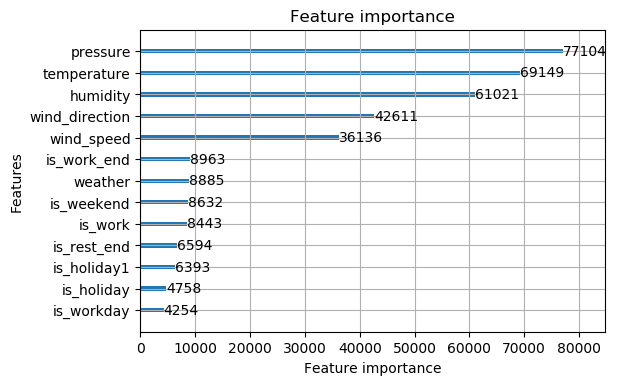

In [22]:
model = PM2_bst
ax = lgb.plot_importance(model, max_num_features=50)
plt.show()

In [23]:
# prediction value and true value 
valid_feature = train_X[:2000]
pm2_label = train_label[:,0]
pm10_label = train_label[:,1]
o3_label = train_label[:,2]
pm2_label = pm2_label[:2000]
pm10_label = pm10_label[:2000]
o3_label = o3_label[:2000]

pm2_pre = PM2_bst.predict(valid_feature)
pm10_pre = PM10_bst.predict(valid_feature)
o3_pre = O3_bst.predict(valid_feature)

Text(0.5, 1.0, 'PM2.5')

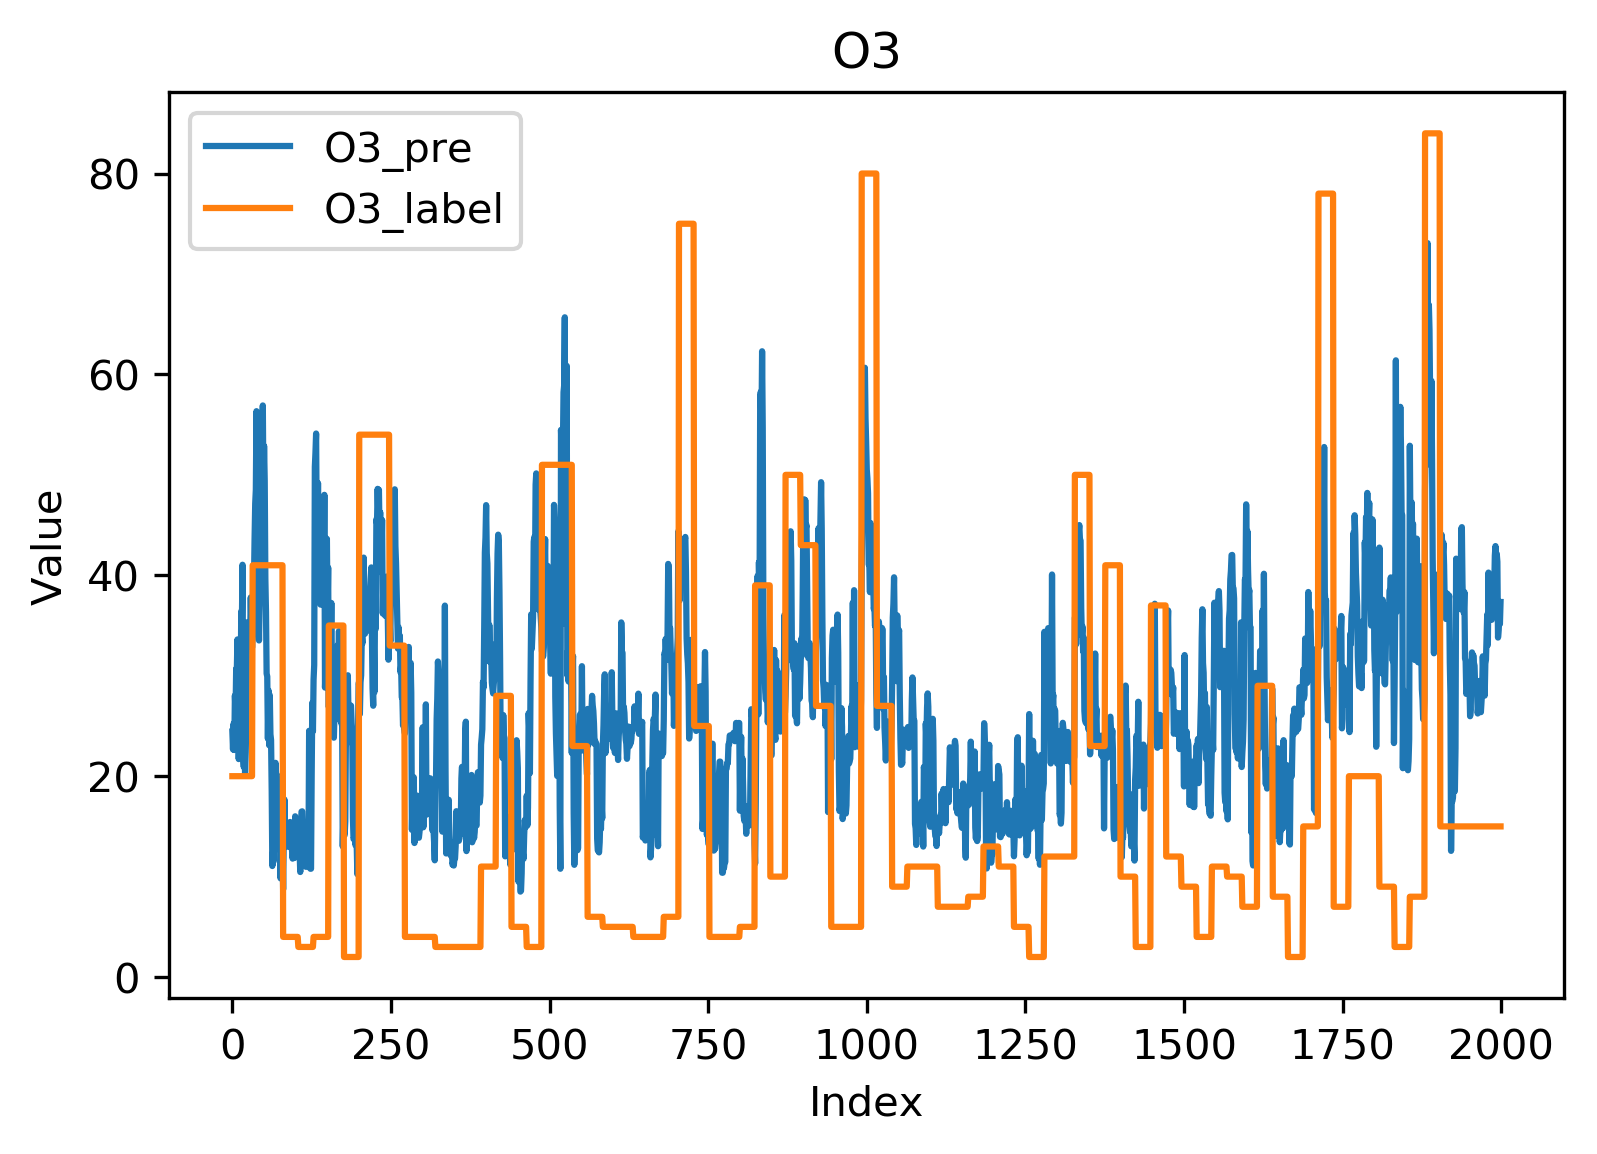

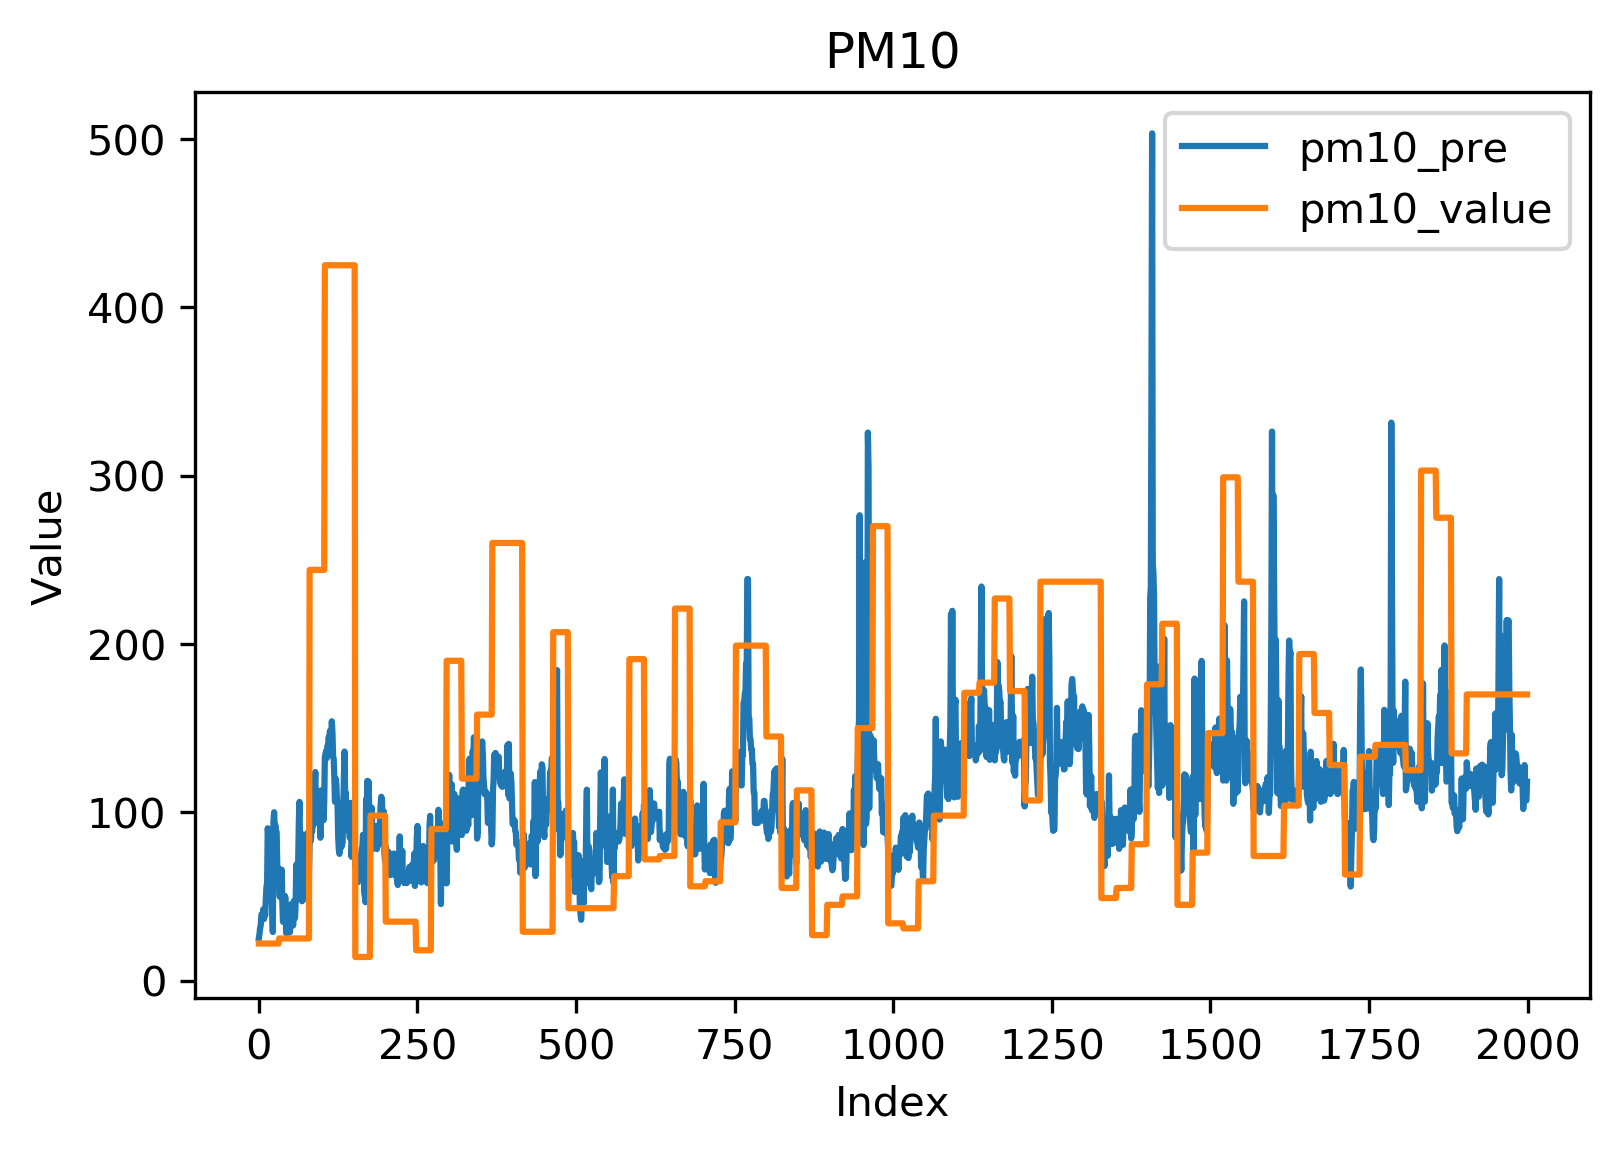

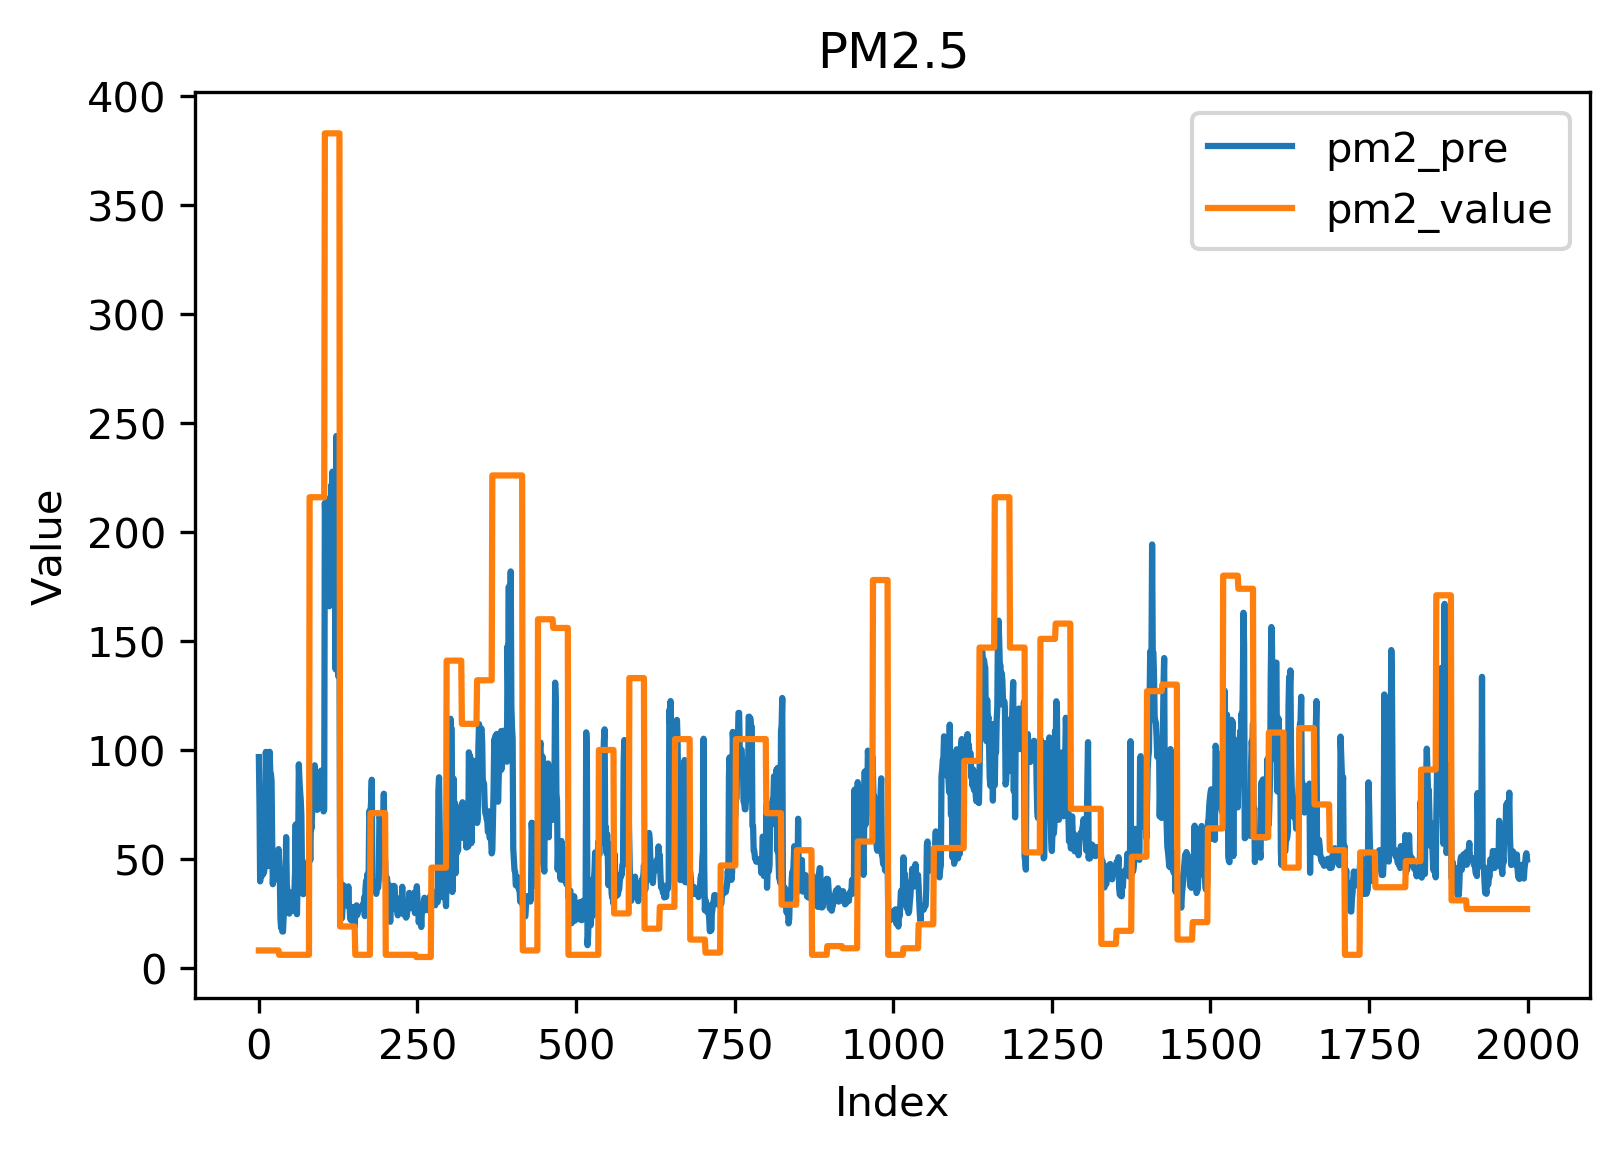

In [24]:
x = range(0, len(o3_pre), 1)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.plot(x, o3_pre, label='O3_pre')
plt.plot(x, o3_label, label = 'O3_label')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('O3')

plt.figure()
x = range(0, len(pm10_pre), 1)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.plot(x, pm10_pre, label='pm10_pre')
plt.plot(x, pm10_label, label = 'pm10_value')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('PM10')

plt.figure()
x = range(0, len(pm2_pre), 1)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.plot(x, pm2_pre, label='pm2_pre')
plt.plot(x, pm2_label, label = 'pm2_value')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('PM2.5')

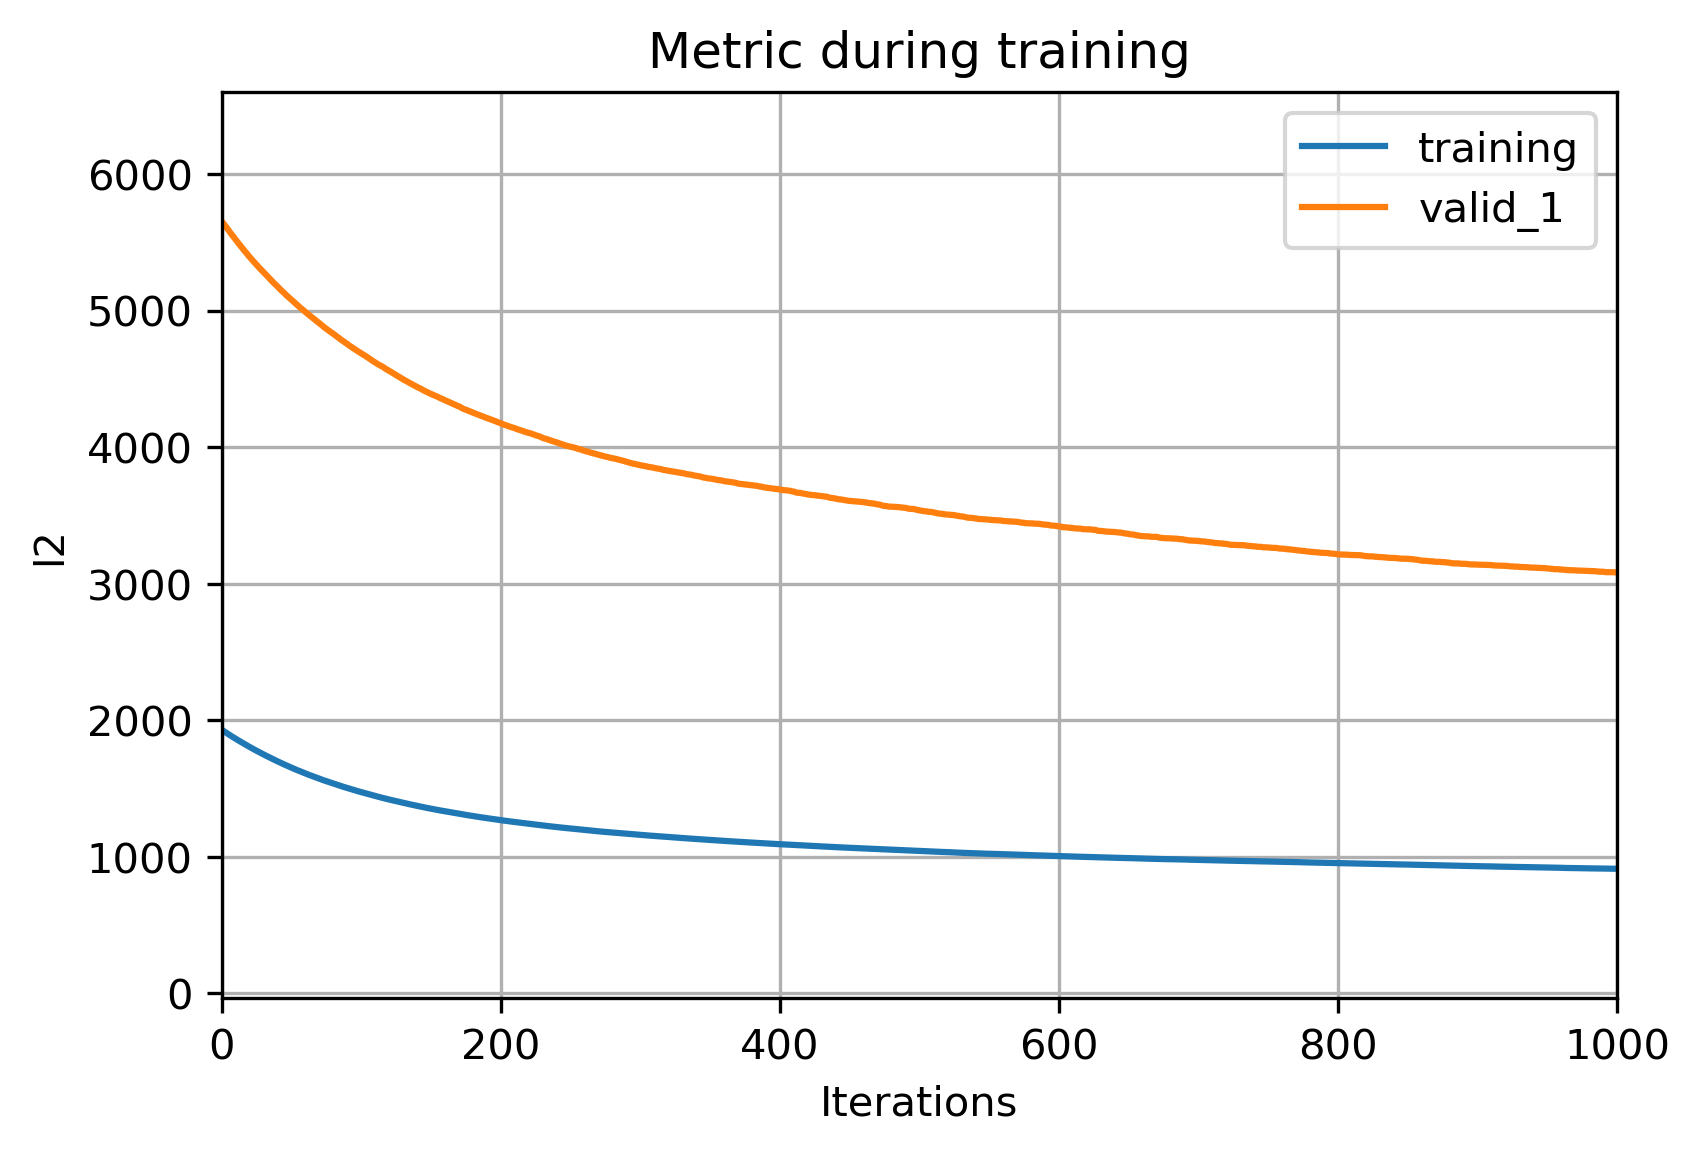

In [25]:
ax = lgb.plot_metric(evals_result_0, metric='l2')
plt.show()